# ResNet Weight-Weight Communication Subspace Analysis

### Import Packages

In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.linalg
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.models import resnet50, ResNet50_Weights, resnet152, ResNet152_Weights
import seaborn as sns
import torchvision.models as models
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from numpy.linalg import LinAlgError
import pickle
import os
import random


### Set Style Settings

In [82]:
# Set color palettes
dark_green = '#006400'
dark_red = '#8b0000'
pal = {'Trained': dark_green, 'Untrained': dark_red}
light_green = '#90ee90'
light_red = '#ffcccb'
face_palette = sns.color_palette([light_green, light_red])

# Increase font size and thickness of axes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 2,
    'xtick.major.width': 2.5,
    'ytick.major.width': 2.5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5
})

In [83]:
# Significance annotation function
# Annotate significance
def add_stat_annotation(ax, x, y, data, hue, p_values):
    # Get the unique modules
    modules = data[x].unique()
    y_max = data[y].max()
    
    for module in modules:
        # Calculate positions for annotations
        trained_data = data[(data[x] == module) & (data[hue] == 'Trained')][y]
        untrained_data = data[(data[x] == module) & (data[hue] == 'Untrained')][y]
        y_min, y_max_trained = trained_data.min(), trained_data.max()
        y_min_untrained, y_max_untrained = untrained_data.min(), untrained_data.max()
        y_max_plot = max(y_max_trained, y_max_untrained)
        
        # Retrieve the p-value
        p_value = p_values[module]
        
        # Determine annotation text
        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.01:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = 'ns'
        
        # Add the annotation
        ax1.text(list(modules).index(module), y_max_plot + 0.03*y_max, annotation, 
                ha='center', va='bottom', color='black', fontsize=14, weight='bold')

## Import ResNet Models

In [84]:
# download trained and untrained models from torchvision
resnet_untrained = resnet50(pretrained=False)
resnet = resnet50(pretrained=True)

# Step 2: Set the models to eval
resnet_untrained.eval()
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [85]:
# print all conv layers in resnet 
# for name, module in resnet.named_modules():
#     if isinstance(module, torch.nn.Conv2d):
#         print(name, module.weight.shape)

In [86]:
def grid_search_and_store_angles(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained, layer_name):
    """
    Parameters:
    - V1: V/U SVD matrix for the trained model - This is the V matrix with the eigenbasis vecotors as columns (Aka the transposed version of the default V matrix from svd)
    - V2: V/U SVD matrix for the trained model
    - V1_untrained: U/V SVD matrix for the untrained model
    - V2_untrained: U/V SVD matrix for the untrained model
    - S1: SVD Singular values matrix for the trained model
    - S2: SVD Singular values matrix for the trained model
    - S1_untrained: Singular values for the untrained model
    - S2_untrained: Singular values for the untrained model
    - layer_name: Name of the layer

    Perform a grid search to find the best number of columns to use for the given layers.
    with the layer names that you want to compare. The primary grid search looks for the first valid combination of columns that has angles greater than 1e-1.
    If no valid combinations are found, the secondary grid search is performed to find the best combination of columns that maximizes the number of angles greater than 1e-1.
    Explained variance is calculated for the best combination of columns found in the primary or secondary grid search based on the number of columns used. 

    Outputs:
    - valid_combinations: List of tuples containing the number of rows and columns for the best combination of columns found
    - angles_trained: List of angles between the trained layers
    - angles_untrained: List of angles between the untrained layers
    - layer_names: List of layer names
    - explained_variances_trained: List of explained variances for the trained layers
    - explained_variances_untrained: List of explained variances for the untrained layers

    """
    
    if V1.shape[0] != V2.shape[0] or V1_untrained.shape[0] != V2_untrained.shape[0]:
        raise ValueError('The number of rows in v/u matrices must be the same')
    # Truncate V1, V2, V1_untrained, V2_untrained to the same dimensions
    min_cols = min(V1.shape[1], V2.shape[1], V1_untrained.shape[1], V2_untrained.shape[1])
    V1 = V1[:, :min_cols]
    V2 = V2[:, :min_cols]
    V1_untrained = V1_untrained[:, :min_cols]
    V2_untrained = V2_untrained[:, :min_cols]
    
    # Truncate singular values
    S1 = S1[:min_cols]
    S2 = S2[:min_cols]
    S1_untrained = S1_untrained[:min_cols]
    S2_untrained = S2_untrained[:min_cols]

    def calculate_explained_variance(S, num_cols):
        total_variance = np.sum(S**2)
        explained_variance = np.sum(S[:num_cols]**2) / total_variance
        return explained_variance

    def primary_grid_search(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained):
        if min(V1.shape[1], V2.shape[1]) > 200:
            num_cols = np.arange(min(V1.shape[1], V2.shape[1]), np.ceil(min(V1.shape[1], V2.shape[1]) / 2), -50).astype(int)
        elif min(V1.shape[1], V2.shape[1]) > 100:
            num_cols = np.arange(min(V1.shape[1], V2.shape[1]), np.ceil(min(V1.shape[1], V2.shape[1]) / 2), -30).astype(int)
        else:
            num_cols = np.arange(min(V1.shape[1], V2.shape[1]), np.ceil(min(V1.shape[1], V2.shape[1]) / 2), -20).astype(int)

        valid_combinations = []
        angles_trained = []
        angles_untrained = []
        layer_names = []
        explained_variances_trained = []
        explained_variances_untrained = []

        found_valid = False
        rows = V1.shape[0]  # Use all rows
        for cols in num_cols:
            V1_subset = V1[:, :cols]
            V2_subset = V2[:, :cols]
            V1_untrained_subset = V1_untrained[:, :cols]
            V2_untrained_subset = V2_untrained[:, :cols]

            try:
                angle_trained = np.degrees(subspace_angles(V1_subset, V2_subset))
                angle_untrained = np.degrees(subspace_angles(V1_untrained_subset, V2_untrained_subset))

                if np.all(angle_trained > 1e-1) and np.all(angle_untrained > 1e-1):
                    valid_combinations.append((rows, cols))
                    angles_trained.append(angle_trained)
                    angles_untrained.append(angle_untrained)
                    layer_names.append(layer_name)
                    
                    # Calculate explained variance
                    ev_trained_1 = calculate_explained_variance(S1, cols)
                    ev_trained_2 = calculate_explained_variance(S2, cols)
                    ev_untrained_1 = calculate_explained_variance(S1_untrained, cols)
                    ev_untrained_2 = calculate_explained_variance(S2_untrained, cols)
                    
                    explained_variances_trained.append((ev_trained_1, ev_trained_2))
                    explained_variances_untrained.append((ev_untrained_1, ev_untrained_2))
                    
                    found_valid = True
                    break  # Stop after the first valid combination is found
            except LinAlgError:
                continue

        return valid_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained

    def secondary_grid_search(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained):
        col_step = max(1, min(V1.shape[1], V2.shape[1]) // 20)
        num_cols = np.arange(min(V1.shape[1], V2.shape[1]), max(1, min(V1.shape[1], V2.shape[1]) // 2), -col_step).astype(int)

        best_combination = None
        best_angles_trained = None
        best_angles_untrained = None
        best_explained_variance_trained = None
        best_explained_variance_untrained = None
        max_count = 0

        rows = V1.shape[0]  # Use all rows
        for cols in num_cols:
            V1_subset = V1[:, :cols]
            V2_subset = V2[:, :cols]
            V1_untrained_subset = V1_untrained[:, :cols]
            V2_untrained_subset = V2_untrained[:, :cols]

            try:
                angle_trained = np.degrees(subspace_angles(V1_subset, V2_subset))
                angle_untrained = np.degrees(subspace_angles(V1_untrained_subset, V2_untrained_subset))

                count_above_threshold_trained = np.sum(angle_trained > 1e-1)
                count_above_threshold_untrained = np.sum(angle_untrained > 1e-1)

                if count_above_threshold_trained + count_above_threshold_untrained > max_count:
                    max_count = count_above_threshold_trained + count_above_threshold_untrained
                    best_combination = (rows, cols)
                    best_angles_trained = angle_trained[angle_trained > 1e-1]  # Filter angles
                    best_angles_untrained = angle_untrained[angle_untrained > 1e-1]  # Filter angles
                    
                    # Calculate explained variance for the best combination
                    ev_trained_1 = calculate_explained_variance(S1, cols)
                    ev_trained_2 = calculate_explained_variance(S2, cols)
                    ev_untrained_1 = calculate_explained_variance(S1_untrained, cols)
                    ev_untrained_2 = calculate_explained_variance(S2_untrained, cols)
                    
                    best_explained_variance_trained = (ev_trained_1, ev_trained_2)
                    best_explained_variance_untrained = (ev_untrained_1, ev_untrained_2)
            except LinAlgError:
                continue

        return best_combination, best_angles_trained, best_angles_untrained, best_explained_variance_trained, best_explained_variance_untrained

    valid_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained = primary_grid_search(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained)

    if not valid_combinations:
        best_combination, best_angles_trained, best_angles_untrained, best_explained_variance_trained, best_explained_variance_untrained = secondary_grid_search(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained)
        valid_combinations = [best_combination]  # Only return the best combination
        angles_trained = [best_angles_trained]
        angles_untrained = [best_angles_untrained]
        layer_names = [layer_name]
        explained_variances_trained = [best_explained_variance_trained]
        explained_variances_untrained = [best_explained_variance_untrained]

    return valid_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained

In [87]:
def compare_UtoV(trained_weights, untrained_weights, layers_to_compare):
    """ 
    Parameters: 
    - trained_weights: Dictionary of trained weights
    - untrained_weights: Dictionary of untrained weights
    - layers_to_compare: List of layers to compare

    Meant for comparison of direct connections between Conv2 and Conv3 layers in the trained and untrained models.

    Outputs:
    - results: Dictionary containing the best combinations of columns, angles, explained variances, and layer names for the given layers.


    """
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'explained_variances_trained': {},
        'explained_variances_untrained': {},
        'pca_explained_variance': {}
    }

    for layer in layers_to_compare:
        print(f'Processing layer: {layer}')
        conv2_weight_trained = trained_weights[f'{layer}.conv2']
        conv3_weight_trained = trained_weights[f'{layer}.conv3']
        conv2_weight_untrained = untrained_weights[f'{layer}.conv2']
        conv3_weight_untrained = untrained_weights[f'{layer}.conv3']

        # SVD for conv2
        U1_trained, S1_trained, _ = np.linalg.svd(conv2_weight_trained, full_matrices=False)
        U1_untrained, S1_untrained, _ = np.linalg.svd(conv2_weight_untrained, full_matrices=False)
        
        # print(f'U Matrix Conv2 Trained Shape: {U1_trained.shape}')
        # print(f'U Matrix Conv2 Untrained Shape: {U1_untrained.shape}')


        # SVD for PCA components
        _, _, V2_trained = np.linalg.svd(conv3_weight_trained, full_matrices=True)
        _, _, V2_untrained = np.linalg.svd(conv3_weight_untrained, full_matrices=True)
        
        V2_trained = V2_trained.T
        V2_untrained = V2_untrained.T
        
        # print(f'Shape of U1 Trained: {U1_trained.shape} Shape of V2 Trained: {V2_trained.shape}')
        # print(f'Shape of U1 Untrained: {U1_untrained.shape} Shape of V2 Untrained: {V2_untrained.shape}')

        # Grid search and store angles
        best_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained = grid_search_and_store_angles(
            U1_trained, V2_trained, U1_untrained, V2_untrained, 
            S1_trained, S1_trained, S1_untrained, S1_untrained, 
            f'{layer}_conv2_to_pca_conv3'
        )

        # Store results
        results['best_combinations'][layer] = best_combinations
        results['angles_trained'][layer] = angles_trained
        results['angles_untrained'][layer] = angles_untrained
        results['layer_names'][layer] = layer_names
        results['explained_variances_trained'][layer] = explained_variances_trained
        results['explained_variances_untrained'][layer] = explained_variances_untrained
        # results['pca_explained_variance'][layer] = {
        #     'trained': pca_trained.explained_variance_ratio_.sum(),
        #     'untrained': pca_untrained.explained_variance_ratio_.sum()
        # }

    return results

In [88]:
def analyze_indirect_UtoV(trained_weights, untrained_weights, layer_pairs):
    """ 
    Parameters: 
    - trained_weights: Dictionary of trained weights
    - untrained_weights: Dictionary of untrained weights
    - layers_to_compare: List of layers to compare

    Meant for comparison of direct connections between Conv1 layer and Conv3 layer of the same block in the trained and untrained models.

    Outputs:
    - results: Dictionary containing the best combinations of columns, angles, explained variances, and layer names for the given layers.
    
    """
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'explained_variances_trained': {},
        'explained_variances_untrained': {},
        'pca_explained_variance': {}
    }

    # Use a set to track unique conv1 layers
    unique_conv1_layers = set()

    for pair in layer_pairs_trained:
        conv1_name = pair['conv1']['name']
        conv3_name = pair['conv3']['name']
        
        if conv1_name in unique_conv1_layers:
            continue

        unique_conv1_layers.add(conv1_name)
        print(f'Processing pair: {conv1_name} <-> {conv3_name}')
        
        conv1_weight_trained = trained_weights[conv1_name]
        conv3_weight_trained = trained_weights[conv3_name]
        conv1_weight_untrained = untrained_weights[conv1_name]
        conv3_weight_untrained = untrained_weights[conv3_name]

        # Perform SVD on trained weights
        U1_trained, S1_trained, V1_trained = np.linalg.svd(conv1_weight_trained, full_matrices=False)
        U3_trained, S3_trained, V3_trained = np.linalg.svd(conv3_weight_trained, full_matrices=False)
        V1_trained = V1_trained.T
        V3_trained = V3_trained.T
        
        # Perform SVD on untrained weights
        U1_untrained, S1_untrained, V1_untrained = np.linalg.svd(conv1_weight_untrained, full_matrices=False)
        U3_untrained, S3_untrained, V3_untrained = np.linalg.svd(conv3_weight_untrained, full_matrices=False)
        V1_untrained = V1_untrained.T
        V3_untrained = V3_untrained.T
        
        # Perform grid search and store angles
        best_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained = grid_search_and_store_angles(
            U1_trained, V3_trained, U1_untrained, V3_untrained, 
            S1_trained, S3_trained, S1_untrained, S3_untrained, conv1_name
        )

        # Store results

        results['best_combinations'][conv1_name] = best_combinations
        results['angles_trained'][conv1_name] = angles_trained
        results['angles_untrained'][conv1_name] = angles_untrained
        results['layer_names'][conv1_name] = layer_names
        results['explained_variances_trained'][conv1_name] = explained_variances_trained
        results['explained_variances_untrained'][conv1_name] = explained_variances_untrained

    return results




In [89]:
def compare_shortskip_UtoV(trained_weights, untrained_weights, sampled_layer_pairs):
    """ 
    Parameters: 
    - trained_weights: Dictionary of trained weights
    - untrained_weights: Dictionary of untrained weights
    - layers_to_compare: List of layers to compare

    Meant for comparison of direct connections between Conv3 layer and Conv1 layer of the next block in the trained and untrained models.

    Outputs:
    - results: Dictionary containing the best combinations of columns, angles, explained variances, and layer names for the given layers.
    
    """
    
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'explained_variances_trained': {},
        'explained_variances_untrained': {},
        'pca_explained_variance': {}
    }

    # Use a set to track unique conv1 layers
    unique_conv1_layers = set()

    for pair in sampled_layer_pairs:
        prev_conv3_name = pair['prev_conv3']['name']
        next_conv1_name = pair['next_conv1']['name']
        
        if next_conv1_name in unique_conv1_layers:
            continue

        unique_conv1_layers.add(next_conv1_name)
        print(f'Processing pair: {prev_conv3_name} -> {next_conv1_name}')

        conv3_weight_trained = trained_weights[prev_conv3_name]
        conv1_weight_trained = trained_weights[next_conv1_name]
        conv3_weight_untrained = untrained_weights[prev_conv3_name]
        conv1_weight_untrained = untrained_weights[next_conv1_name]

        # Perform SVD on trained weights
        U3_trained, S3_trained, V3_trained = np.linalg.svd(conv3_weight_trained, full_matrices=False)
        U1_trained, S1_trained, V1_trained = np.linalg.svd(conv1_weight_trained, full_matrices=False)
        V3_trained = V3_trained.T
        V1_trained = V1_trained.T
        
        # Perform SVD on untrained weights
        U3_untrained, S3_untrained, V3_untrained = np.linalg.svd(conv3_weight_untrained, full_matrices=False)
        U1_untrained, S1_untrained, V1_untrained = np.linalg.svd(conv1_weight_untrained, full_matrices=False)
        V3_untrained = V3_untrained.T
        V1_untrained = V1_untrained.T
        
        # Perform grid search and store angles
        best_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained = grid_search_and_store_angles(
            U3_trained, V1_trained, U3_untrained, V1_untrained, 
            S3_trained, S1_trained, S3_untrained, S1_untrained, next_conv1_name
        )
        
        # Store results
        results['best_combinations'][next_conv1_name] = best_combinations
        results['angles_trained'][next_conv1_name] = angles_trained
        results['angles_untrained'][next_conv1_name] = angles_untrained
        results['layer_names'][next_conv1_name] = layer_names
        results['explained_variances_trained'][next_conv1_name] = explained_variances_trained
        results['explained_variances_untrained'][next_conv1_name] = explained_variances_untrained



    return results

In [90]:
def analyze_longskip_UtoV(trained_weights, untrained_weights, layer_pairs):
    """ 
    Parameters: 
    - trained_weights: Dictionary of trained weights
    - untrained_weights: Dictionary of untrained weights
    - layers_to_compare: List of layers to compare

    Meant for comparison of direct connections between Conv1 layer and Conv1 layer of the next block in the trained and untrained models.

    Outputs:
    - results: Dictionary containing the best combinations of columns, angles, explained variances, and layer names for the given layers.
    
    """    
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'explained_variances_trained': {},
        'explained_variances_untrained': {},
        'pca_explained_variance': {}
    }

    for pair in layer_pairs_trained:
        prev_conv1_name = pair['prev_conv1']['name']
        next_conv1_name = pair['next_conv1']['name']
        
        print(f'Processing pair: {prev_conv1_name} -> {next_conv1_name}')
        
        conv1_weight_trained = trained_weights[prev_conv1_name]
        next_conv1_weight_trained = trained_weights[next_conv1_name]
        conv1_weight_untrained = untrained_weights[prev_conv1_name]
        next_conv1_weight_untrained = untrained_weights[next_conv1_name]

        # Perform SVD on trained weights
        U1_trained, S1_trained, V1_trained = np.linalg.svd(conv1_weight_trained, full_matrices=False)
        U_next_trained, S_next_trained, V_next_trained = np.linalg.svd(next_conv1_weight_trained, full_matrices=False)
        V1_trained = V1_trained.T
        V_next_trained = V_next_trained.T
        
        # Perform SVD on untrained weights
        U1_untrained, S1_untrained, V1_untrained = np.linalg.svd(conv1_weight_untrained, full_matrices=False)
        U_next_untrained, S_next_untrained, V_next_untrained = np.linalg.svd(next_conv1_weight_untrained, full_matrices=False)
        V1_untrained = V1_untrained.T
        V_next_untrained = V_next_untrained.T
        
        # Perform grid search and store angles
        best_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained = grid_search_and_store_angles(
            V1_trained, V_next_trained, V1_untrained, V_next_untrained, 
            S1_trained, S_next_trained, S1_untrained, S_next_untrained, next_conv1_name
        )

        # Store results
        results['best_combinations'][next_conv1_name] = best_combinations
        results['angles_trained'][next_conv1_name] = angles_trained
        results['angles_untrained'][next_conv1_name] = angles_untrained
        results['layer_names'][next_conv1_name] = layer_names
        results['explained_variances_trained'][next_conv1_name] = explained_variances_trained
        results['explained_variances_untrained'][next_conv1_name] = explained_variances_untrained

    return results

In [91]:
def analyze_branching_pairs(trained_skip_pairs, untrained_skip_pairs, layers_to_compare):
    """ 
    Parameters: 
    - trained_weights: Dictionary of trained weights
    - untrained_weights: Dictionary of untrained weights
    - layers_to_compare: List of layers to compare

    Meant for comparison of direct connections between Conv1 layer and Downsample layer of the smae block in the trained and untrained models.

    Outputs:
    - results: Dictionary containing the best combinations of columns, angles, explained variances, and layer names for the given layers.
    
    """   
    
    # Initialize dictionaries to store results
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'explained_variances_trained': {},
        'explained_variances_untrained': {}
    }

    for layer in layers_to_compare:
        print(f'Processing layer: {layer}')
        if layer in trained_skip_pairs and layer in untrained_skip_pairs:
            normal_weight_trained = trained_skip_pairs[layer]['first_conv']
            skip_weight_trained = trained_skip_pairs[layer]['skip_conv']
            normal_weight_untrained = untrained_skip_pairs[layer]['first_conv']
            skip_weight_untrained = untrained_skip_pairs[layer]['skip_conv']

            # Perform SVD on trained weights
            U1_trained, S1_trained, V1_trained = np.linalg.svd(normal_weight_trained, full_matrices=False)
            U2_trained, S2_trained, V2_trained = np.linalg.svd(skip_weight_trained, full_matrices=False)
            V1_trained = V1_trained.T
            V2_trained = V2_trained.T
            
            # Perform SVD on untrained weights
            U1_untrained, S1_untrained, V1_untrained = np.linalg.svd(normal_weight_untrained, full_matrices=False)
            U2_untrained, S2_untrained, V2_untrained = np.linalg.svd(skip_weight_untrained, full_matrices=False)
            V1_untrained = V1_untrained.T
            V2_untrained = V2_untrained.T
            
            # Perform grid search and store angles
            best_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained = grid_search_and_store_angles(
                V1_trained, V2_trained, V1_untrained, V2_untrained, 
                S1_trained, S2_trained, S1_untrained, S2_untrained, layer
            )
            
            # Store results
            results['best_combinations'][layer] = best_combinations
            results['angles_trained'][layer] = angles_trained
            results['angles_untrained'][layer] = angles_untrained
            results['layer_names'][layer] = layer_names
            results['explained_variances_trained'][layer] = explained_variances_trained
            results['explained_variances_untrained'][layer] = explained_variances_untrained
        else:
            print(f"Skip connection not found for layer: {layer}")

    return results

In [92]:
# function to save results of analysis to pickle file
def save_results(results, filename):
    pickle_folder = 'pickle'
    os.makedirs(pickle_folder, exist_ok=True)
    
    with open(os.path.join(pickle_folder, filename), 'wb') as f:
        pickle.dump(results, f)

In [93]:
def load_and_process_results(filename):
    """
    Parameters: Filename of pickle file containing the results of the analysis in the form of 
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'explained_variances_trained': {},
        'explained_variances_untrained': {}
    }

    Outputs:
    - angles_trained_dict: Dictionary containing the angles between the trained layers
    - angles_untrained_dict: Dictionary containing the angles between the untrained layers
    - data: Pandas DataFrame containing the angles between the trained and untrained layers, the Model (Trained or Untrained), and the Module name
    - ev_data: Pandas DataFrame containing the explained variances for the trained and untrained layers, and the Module name. 

    """
    with open(os.path.join('pickle', filename), 'rb') as f:
        all_data = pickle.load(f)
    # Extract the individual dictionaries
    angles_trained_dict = all_data['angles_trained']
    angles_untrained_dict = all_data['angles_untrained']
    explained_variances_trained_dict = all_data['explained_variances_trained']
    explained_variances_untrained_dict = all_data['explained_variances_untrained']

    trained_data = []
    untrained_data = []
    trained_module_names = []
    untrained_module_names = []
    trained_ev_data = []
    untrained_ev_data = []

    # Debugging: print types and examples of the data
    print("angles_trained_dict keys:", list(angles_trained_dict.keys()))
    print("angles_untrained_dict keys:", list(angles_untrained_dict.keys()))
    print("Example trained angles type:", type(next(iter(angles_trained_dict.values()))))
    print("Example untrained angles type:", type(next(iter(angles_untrained_dict.values()))))
    print("Example SVD EV trained type:", type(next(iter(explained_variances_trained_dict.values()))))
    print("Example SVD EV untrained type:", type(next(iter(explained_variances_untrained_dict.values()))))
   

    for layer in angles_trained_dict.keys():
        trained_angles = angles_trained_dict[layer]
        trained_ev = explained_variances_trained_dict[layer]
        if not isinstance(trained_angles, np.ndarray):
            flat_angles = np.concatenate(trained_angles)
        else:
            flat_angles = trained_angles
        trained_data.extend(flat_angles)
        trained_module_names.extend([layer] * len(flat_angles))
        trained_ev_data.append(np.mean(trained_ev))

    for layer in angles_untrained_dict.keys():
        untrained_angles = angles_untrained_dict[layer]
        untrained_ev = explained_variances_untrained_dict[layer]
        if not isinstance(untrained_angles, np.ndarray):
            flat_angles = np.concatenate(untrained_angles)
        else:
            flat_angles = untrained_angles
        untrained_data.extend(flat_angles)
        untrained_module_names.extend([layer] * len(flat_angles))
        untrained_ev_data.append(np.mean(untrained_ev))

    # print(f"Number of trained angles: {len(trained_data)}")
    # print(f"Number of untrained angles: {len(untrained_data)}")

    # Create a DataFrame for easier plotting with seaborn
    data = pd.DataFrame({
        'Angle (degrees)': trained_data + untrained_data,
        'Model': ['Trained'] * len(trained_data) + ['Untrained'] * len(untrained_data),
        'Module': trained_module_names + untrained_module_names
    })

    # Debugging: print the resulting DataFrame info
    print("Data DataFrame info:")
    print(data.info())
    print(data.head())

    # Create a DataFrame for explained variance
    ev_data = pd.DataFrame({
        'Module': list(angles_trained_dict.keys()),
        'Trained_EV': trained_ev_data,
        'Untrained_EV': untrained_ev_data
    })


    # Debugging: print the resulting ev_data DataFrame info
    print("EV DataFrame info:")
    print(ev_data.info())
    print(ev_data.head())
    
    return (angles_trained_dict, angles_untrained_dict, data, ev_data)

In [94]:
def load_and_process_results_skip(filename):
    """
    Parameters: Filename of pickle file containing the results of the analysis.

    Outputs:
    - angles_trained_dict: Dictionary containing the angles between the trained layers
    - angles_untrained_dict: Dictionary containing the angles between the untrained layers
    - data: Pandas DataFrame containing the angles between the trained and untrained layers, the Model (Trained or Untrained), and the Module name
    - ev_data: Pandas DataFrame containing the explained variances for the trained and untrained layers, and the Module name. 
    """
    with open(os.path.join('pickle', filename), 'rb') as f:
        all_data = pickle.load(f)
    
    # Extract the individual dictionaries
    angles_trained_dict = all_data['angles_trained']
    angles_untrained_dict = all_data['angles_untrained']
    explained_variances_trained_dict = all_data['explained_variances_trained']
    explained_variances_untrained_dict = all_data['explained_variances_untrained']

    # Filter out layers containing '.0'
    angles_trained_dict = {k: v for k, v in angles_trained_dict.items() if '.0' not in k}
    angles_untrained_dict = {k: v for k, v in angles_untrained_dict.items() if '.0' not in k}
    explained_variances_trained_dict = {k: v for k, v in explained_variances_trained_dict.items() if '.0' not in k}
    explained_variances_untrained_dict = {k: v for k, v in explained_variances_untrained_dict.items() if '.0' not in k}

    trained_data = []
    untrained_data = []
    trained_module_names = []
    untrained_module_names = []
    trained_ev_data = []
    untrained_ev_data = []

    for layer in angles_trained_dict.keys():
        trained_angles = angles_trained_dict[layer]
        trained_ev = explained_variances_trained_dict[layer]
        if not isinstance(trained_angles, np.ndarray):
            flat_angles = np.concatenate(trained_angles)
        else:
            flat_angles = trained_angles
        trained_data.extend(flat_angles)
        trained_module_names.extend([layer] * len(flat_angles))
        trained_ev_data.append(np.mean(trained_ev))

    for layer in angles_untrained_dict.keys():
        untrained_angles = angles_untrained_dict[layer]
        untrained_ev = explained_variances_untrained_dict[layer]
        if not isinstance(untrained_angles, np.ndarray):
            flat_angles = np.concatenate(untrained_angles)
        else:
            flat_angles = untrained_angles
        untrained_data.extend(flat_angles)
        untrained_module_names.extend([layer] * len(flat_angles))
        untrained_ev_data.append(np.mean(untrained_ev))

    # Create a DataFrame for easier plotting with seaborn
    data = pd.DataFrame({
        'Angle (degrees)': trained_data + untrained_data,
        'Model': ['Trained'] * len(trained_data) + ['Untrained'] * len(untrained_data),
        'Module': trained_module_names + untrained_module_names
    })

    # Create a DataFrame for explained variance
    ev_data = pd.DataFrame({
        'Module': list(angles_trained_dict.keys()),
        'Trained_EV': trained_ev_data,
        'Untrained_EV': untrained_ev_data
    })

    return (angles_trained_dict, angles_untrained_dict, data, ev_data)

In [95]:
def test_normality_and_compare(trained_angles, untrained_angles):
    """ 
    Parameters: List of trained and untrained angles

    Tests for normality using the Shapiro-Wilk test and compares the trained and untrained angles using either
    Welch's t-test or Mann-Whitney U test based on the normality of the data.

    Outputs: Name of test used and p-value

    """
    # Test for normality
    stat_trained, p_trained = shapiro(trained_angles)
    stat_untrained, p_untrained = shapiro(untrained_angles)
    
    print(f"Shapiro-Wilk test for trained angles: Statistic={stat_trained}, p-value={p_trained}")
    print(f"Shapiro-Wilk test for untrained angles: Statistic={stat_untrained}, p-value={p_untrained}")
    
    if p_trained > 0.05 and p_untrained > 0.05:
        # Both datasets are normally distributed
        t_stat, p_value = ttest_ind(trained_angles, untrained_angles, equal_var=False)
        test_name = "Welch's t-test"
    else:
        # At least one dataset is not normally distributed
        u_stat, p_value = mannwhitneyu(trained_angles, untrained_angles)
        test_name = "Mann-Whitney U test"
    
    print(f"{test_name} results: Statistic={t_stat if 't_stat' in locals() else u_stat}, p-value={p_value}")
    return test_name, p_value    

In [96]:
def get_p_values(angles_trained_dict, angles_untrained_dict):
    """ 
    Parameters: Dictionaries containing the angles between the trained and untrained layers

    Creates dictionary for the p-values of each layer based on the comparison of the trained and untrained angles.

    Outputs: Dictionary containing the p-values for each layer


    """
    p_values = {}

    for layer in angles_trained_dict.keys():
        trained_angles = angles_trained_dict[layer]
        untrained_angles = angles_untrained_dict[layer]
        
        # Check if the angles are lists of arrays or single arrays
        if isinstance(trained_angles, list):
            trained_angles = np.concatenate(trained_angles)
        if isinstance(untrained_angles, list):
            untrained_angles = np.concatenate(untrained_angles)
        
        print(f"\nComparing angles for module {layer}:")
        test_name, p_value = test_normality_and_compare(trained_angles, untrained_angles)
        
        if p_value < 0.05:
            print(f"Significant difference found in {layer} with {test_name}.")
        else:
            print(f"No significant difference found in {layer} with {test_name}.")
        
        p_values[layer] = p_value

    return p_values

## Analyze Branching Connections

In [97]:
def extract_downsample_skip_pairs(model):
    skip_pairs = {}
    
    for name, module in model.named_modules():
        if isinstance(module, (models.resnet.Bottleneck, models.resnet.BasicBlock)):
            # Extract the first convolution layer of the block
            first_conv = module.conv1
            first_conv_weight = first_conv.weight.data.clone().detach()
            
            # Check if there is a downsample (skip connection)
            if hasattr(module, 'downsample') and module.downsample is not None:
                skip_conv = module.downsample[0]
                skip_conv_weight = skip_conv.weight.data.clone().detach()
                
                # Unfold weights
                unfolded_first_conv = unfold_weights(first_conv_weight, first_conv)
                unfolded_skip_conv = unfold_weights(skip_conv_weight, skip_conv)
                
                # Store the pair
                skip_pairs[name] = {
                    'first_conv': unfolded_first_conv,
                    'skip_conv': unfolded_skip_conv
                }

    return skip_pairs

# Unfold the weights so that they can be used for SVD

def unfold_weights(weight, conv_layer):
    out_channels, in_channels, kernel_height, kernel_width = weight.shape
    
    unfold = nn.Unfold(kernel_size=(kernel_height, kernel_width),
                       dilation=conv_layer.dilation,
                       padding=0,
                       stride=1)
    
    # Apply unfold directly to the weight tensor
    unfolded = unfold(weight)
    
    # Reshape to (out_channels, in_channels * kernel_height * kernel_width)
    unfolded = unfolded.view(out_channels, -1)
    print(f'Unfolded shape: {unfolded.shape}')

    return unfolded.cpu().numpy()



In [98]:
# Extract weights for both models
trained_skip_pairs = extract_downsample_skip_pairs(resnet)
untrained_skip_pairs = extract_downsample_skip_pairs(resnet_untrained)

# print pairs
# for name, pair in trained_skip_pairs.items():
#     print(f'Layer: {name}')
#     print(f'First Conv Weight Shape: {pair["first_conv"].shape}')
#     print(f'Skip Conv Weight Shape: {pair["skip_conv"].shape}')
#     print()

Unfolded shape: torch.Size([64, 64])
Unfolded shape: torch.Size([256, 64])
Unfolded shape: torch.Size([128, 256])
Unfolded shape: torch.Size([512, 256])
Unfolded shape: torch.Size([256, 512])
Unfolded shape: torch.Size([1024, 512])
Unfolded shape: torch.Size([512, 1024])
Unfolded shape: torch.Size([2048, 1024])
Unfolded shape: torch.Size([64, 64])
Unfolded shape: torch.Size([256, 64])
Unfolded shape: torch.Size([128, 256])
Unfolded shape: torch.Size([512, 256])
Unfolded shape: torch.Size([256, 512])
Unfolded shape: torch.Size([1024, 512])
Unfolded shape: torch.Size([512, 1024])
Unfolded shape: torch.Size([2048, 1024])


In [99]:

# Define layers to compare
layers_to_compare = ['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0']

# # Analyze skip pairs
# results = analyze_branching_pairs(trained_skip_pairs, untrained_skip_pairs, layers_to_compare)

In [100]:
# save_results(results, 'unf_ev_resnet50_conv1toD.pkl')
    
# Now load and process the results
filename = 'unf_ev_resnet50_conv1toD.pkl'
with open(os.path.join('pickle', filename), 'rb') as f:
        branching_results = pickle.load(f)
(angles_trained_dict, angles_untrained_dict, data, ev_data) = load_and_process_results('unf_ev_resnet50_conv1toD.pkl')


angles_trained_dict keys: ['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0']
angles_untrained_dict keys: ['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0']
Example trained angles type: <class 'list'>
Example untrained angles type: <class 'list'>
Example SVD EV trained type: <class 'list'>
Example SVD EV untrained type: <class 'list'>
Data DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Angle (degrees)  1651 non-null   float32
 1   Model            1651 non-null   object 
 2   Module           1651 non-null   object 
dtypes: float32(1), object(2)
memory usage: 32.4+ KB
None
   Angle (degrees)    Model    Module
0        88.668655  Trained  layer1.0
1        85.474670  Trained  layer1.0
2        82.924149  Trained  layer1.0
3        72.481911  Trained  layer1.0
4        71.273933  Trained  layer1.0
EV DataFrame info:
<class

In [101]:
p_values = get_p_values(angles_trained_dict, angles_untrained_dict)
print(p_values)
# # save p_values to pickle file called "weight_to_weight_branching_p_values.pkl"
save_results(p_values, 'weight_to_weight_branching_p_values.pkl')



Comparing angles for module layer1.0:
Shapiro-Wilk test for trained angles: Statistic=0.8272179448888365, p-value=0.0002676796804139698
Shapiro-Wilk test for untrained angles: Statistic=0.9542687045455591, p-value=0.21965390718187044
Mann-Whitney U test results: Statistic=250.0, p-value=0.0051518616904822154
Significant difference found in layer1.0 with Mann-Whitney U test.

Comparing angles for module layer2.0:
Shapiro-Wilk test for trained angles: Statistic=0.903229079403214, p-value=1.3795511512732103e-07
Shapiro-Wilk test for untrained angles: Statistic=0.9537413998475394, p-value=0.0002508560753971282
Mann-Whitney U test results: Statistic=5985.0, p-value=0.0001953700401384099
Significant difference found in layer2.0 with Mann-Whitney U test.

Comparing angles for module layer3.0:
Shapiro-Wilk test for trained angles: Statistic=0.9218341050451733, p-value=5.3484469214579166e-09
Shapiro-Wilk test for untrained angles: Statistic=0.958771794683836, p-value=1.0919228515816363e-05
Man

#### Boxplot and Lineplot for Downsample Branching 

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3117/2510863.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['1.0', '2.0', '3.0', '4.0'], weight='bold', fontsize=16)


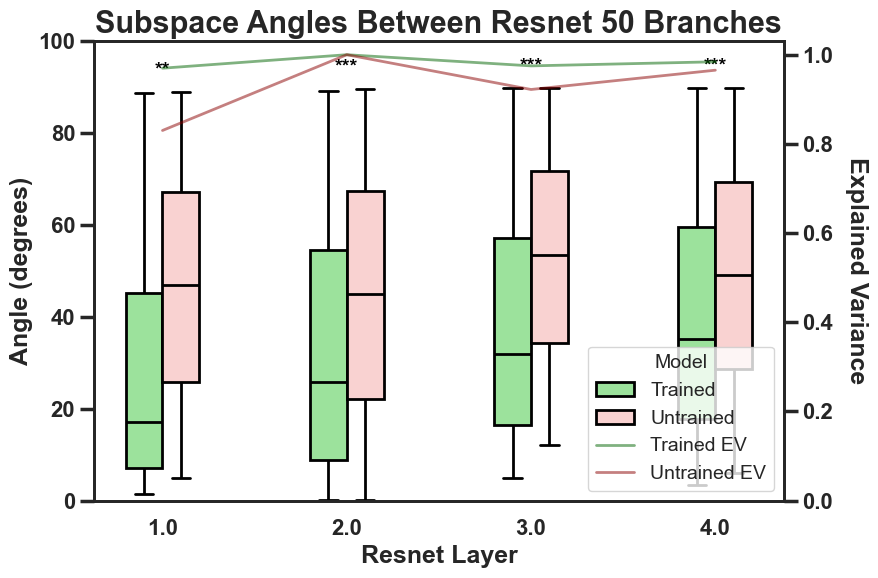

In [102]:
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(9, 6))

# Create the boxplot with seaborn
sns.boxplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            boxprops={'edgecolor': 'k', 'linewidth': 2}, 
            medianprops={'color': 'k', 'linewidth': 2}, 
            whiskerprops={'color': 'k', 'linewidth': 2}, 
            capprops={'color': 'k', 'linewidth': 2}, 
            width=0.4, palette=face_palette, ax=ax1, dodge=True)

# Customize the plot
ax1.set_title('Subspace Angles Between Resnet 50 Branches', weight='bold', fontsize=22)
ax1.set_ylabel('Angle (degrees)', weight='bold', fontsize=18)
ax1.set_xlabel('Resnet Layer', weight='bold', fontsize=18)
ax1.set_xticklabels(['1.0', '2.0', '3.0', '4.0'], weight='bold', fontsize=16)
ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(0, 100)
# make the y ticks bold
plt.yticks(fontweight='bold', fontsize=16)
# Create secondary y-axis for explained variance
ax2 = ax1.twinx()

# Plot explained variance for trained and untrained models with solid, semi-transparent lines
ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
         alpha=0.5, linewidth=2, label='Trained EV')
ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
         alpha=0.5, linewidth=2, label='Untrained EV')

ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25, fontsize=18)
ax2.set_ylim(0, 1.03)
plt.yticks(fontweight='bold', fontsize=16)
# Add legend for explained variance
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')

# Add statistical annotations
add_stat_annotation(ax1, 'Module', 'Angle (degrees)', data, 'Model', p_values)
plt.tight_layout()
plt.show()

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3117/4065633661.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['1.0', '2.0', '3.0', '4.0'], weight='bold', ha='right', rotation=45)


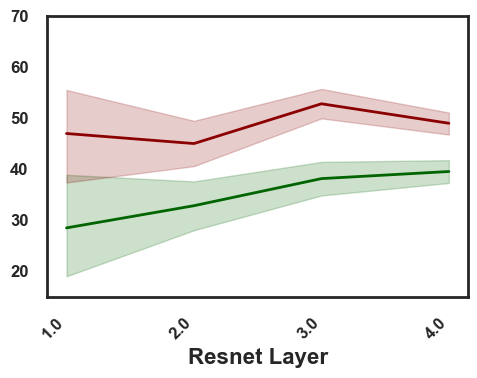

In [103]:
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(5, 4))

# Create the line plot with seaborn for angles
sns.lineplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            linewidth=2, palette=pal, ax=ax1, legend=False)

# Customize the plot
# ax1.set_title('Mean Subspace Angles and Explained Variance Between Resnet 50 Branches', weight='bold')
ax1.set_ylabel('', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold', fontsize=16)
ax1.set_xticklabels(['1.0', '2.0', '3.0', '4.0'], weight='bold', ha='right', rotation=45)
# ax1.legend(title='Model', loc='upper right', fontsize=12)
ax1.set_ylim(15, 70)
plt.yticks(fontweight='bold')

# # Create secondary y-axis for explained variance
# ax2 = ax1.twinx()

# # Plot explained variance for trained and untrained models
# ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Trained EV')
# ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Untrained EV')

# ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
# ax2.set_ylim(0, 1)
plt.yticks(fontweight='bold')
# Combine legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')
# ax1.legend(lines1 , labels1 , loc='lower right', title='Model')

plt.tight_layout()
plt.show()

In [104]:
def calculate_column_usage_percentage(results, skip_pairs):
    usage_data = []
    
    for layer, best_combination in results['best_combinations'].items():
        if layer in skip_pairs:
            unfolded_first_conv = skip_pairs[layer]['first_conv']
            
            total_columns = unfolded_first_conv.shape[1]
            
            # Since best_combination is a list of tuples, extract the first tuple
            _, used_columns = best_combination[0]
            
            percentage_used = (used_columns / total_columns) * 100
            
            usage_data.append({
                'Layer': layer,
                'Percentage Used': percentage_used
            })
    
    return pd.DataFrame(usage_data)

In [105]:
def plot_column_usage_percentage(usage_data, module_names):
    plt.figure(figsize=(5, 5))
    
    # Define a color set
    color_set = sns.color_palette('hls', n_colors=len(usage_data))
    # Create x-tick labels without the 'layer' prefix
    x_ticks = [name[5:] if name.startswith('layer') else name for name in module_names]
    
    # Create the bar plot
    bars = plt.bar(range(len(usage_data)), usage_data['Percentage Used'], 
                   color=color_set[:len(usage_data)])
    
    plt.title('Dimensionality of Subspace', fontweight='bold', fontsize=20)
    plt.xlabel('Resnet Layer', fontweight='bold', fontsize=18)
    plt.ylabel('Percentage of Total Dimensions', fontweight='bold', fontsize=18)
    plt.ylim(0, 100)  # Set y-axis limits from 0 to 100%
    plt.yticks(fontweight='bold', fontsize=16)
    # Set the x-ticks and labels
    plt.xticks(range(len(usage_data)), x_ticks, rotation=45, ha='right', fontweight='bold', fontsize=16)
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%',
                 ha='center', va='bottom', fontweight='bold', fontsize=18)
    
    plt.tight_layout()
    plt.show()


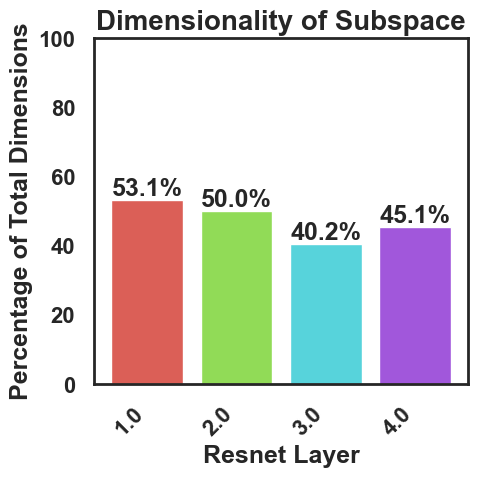

In [106]:
# This is a plot showing how many column dimensions are used in the subspace for each layer relative to the total number of column dimensions in the weight matrix
usage_data = calculate_column_usage_percentage(branching_results, trained_skip_pairs)

module_names = list(angles_trained_dict.keys())
plot_column_usage_percentage(usage_data, module_names)


# Branching Direct Connections

These are the direct connections between source and target layers with branching e.g. Conv3 of block 1.2 to Conv1 or the Downsample layer in Block 2.0. 

In [107]:
def extract_branching_connections(model):
    connections = {}
    prev_conv3 = None
    current_stage = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if name == 'conv1':
                connections['initial'] = {
                    'from': unfold_weights(module.weight.data, module),
                    'to_conv1': None,
                    'to_downsample': None
                }
            elif '.0.conv1' in name:
                current_stage += 1
                if current_stage == 1:
                    connections['initial']['to_conv1'] = unfold_weights(module.weight.data, module)
                else:
                    connections[f'layer{current_stage-1}.{3 if current_stage > 2 else 2}.conv3'] = {
                        'from': prev_conv3,
                        'to_conv1': unfold_weights(module.weight.data, module),
                        'to_downsample': None
                    }
            elif '.0.downsample.0' in name:
                if current_stage == 1:
                    connections['initial']['to_downsample'] = unfold_weights(module.weight.data, module)
                else:
                    connections[f'layer{current_stage-1}.{3 if current_stage > 2 else 2}.conv3']['to_downsample'] = unfold_weights(module.weight.data, module)
            elif 'conv3' in name:
                stage_num = int(name.split('.')[0][-1])
                block_num = int(name.split('.')[1])
                if (stage_num == 1 and block_num == 2) or (stage_num > 1 and block_num == 3):
                    prev_conv3 = unfold_weights(module.weight.data, module)

    return connections

In [108]:
branching_connections_trained = extract_branching_connections(resnet)
branching_connections_untrained = extract_branching_connections(resnet_untrained)

Unfolded shape: torch.Size([64, 147])
Unfolded shape: torch.Size([64, 64])
Unfolded shape: torch.Size([256, 64])
Unfolded shape: torch.Size([256, 64])
Unfolded shape: torch.Size([128, 256])
Unfolded shape: torch.Size([512, 256])
Unfolded shape: torch.Size([512, 128])
Unfolded shape: torch.Size([256, 512])
Unfolded shape: torch.Size([1024, 512])
Unfolded shape: torch.Size([1024, 256])
Unfolded shape: torch.Size([512, 1024])
Unfolded shape: torch.Size([2048, 1024])
Unfolded shape: torch.Size([64, 147])
Unfolded shape: torch.Size([64, 64])
Unfolded shape: torch.Size([256, 64])
Unfolded shape: torch.Size([256, 64])
Unfolded shape: torch.Size([128, 256])
Unfolded shape: torch.Size([512, 256])
Unfolded shape: torch.Size([512, 128])
Unfolded shape: torch.Size([256, 512])
Unfolded shape: torch.Size([1024, 512])
Unfolded shape: torch.Size([1024, 256])
Unfolded shape: torch.Size([512, 1024])
Unfolded shape: torch.Size([2048, 1024])


In [109]:
# Print the extracted connections
for key, value in branching_connections_trained.items():
    print(f"Connection: {key}")
    for k, v in value.items():
        print(f"  {k}: shape {v.shape}")
    print()

Connection: initial
  from: shape (64, 147)
  to_conv1: shape (64, 64)
  to_downsample: shape (256, 64)

Connection: layer1.2.conv3
  from: shape (256, 64)
  to_conv1: shape (128, 256)
  to_downsample: shape (512, 256)

Connection: layer2.3.conv3
  from: shape (512, 128)
  to_conv1: shape (256, 512)
  to_downsample: shape (1024, 512)

Connection: layer3.3.conv3
  from: shape (1024, 256)
  to_conv1: shape (512, 1024)
  to_downsample: shape (2048, 1024)



In [110]:
def analyze_branching_direct_connections(trained_connections, untrained_connections):
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'explained_variances_trained': {},
        'explained_variances_untrained': {}
    }

    for layer in trained_connections.keys():
        print(f'Processing layer: {layer}')
        if layer in untrained_connections:
            from_weight_trained = trained_connections[layer]['from']
            to_conv1_weight_trained = trained_connections[layer]['to_conv1']
            to_downsample_weight_trained = trained_connections[layer]['to_downsample']

            from_weight_untrained = untrained_connections[layer]['from']
            to_conv1_weight_untrained = untrained_connections[layer]['to_conv1']
            to_downsample_weight_untrained = untrained_connections[layer]['to_downsample']

            # Perform SVD on trained weights
            U_from_trained, S_from_trained, _ = np.linalg.svd(from_weight_trained, full_matrices=False)
            _, S_to_conv1_trained, V_to_conv1_trained = np.linalg.svd(to_conv1_weight_trained, full_matrices=False)
            _, S_to_downsample_trained, V_to_downsample_trained = np.linalg.svd(to_downsample_weight_trained, full_matrices=False)
            
            # Perform SVD on untrained weights
            U_from_untrained, S_from_untrained, _ = np.linalg.svd(from_weight_untrained, full_matrices=False)
            _, S_to_conv1_untrained, V_to_conv1_untrained = np.linalg.svd(to_conv1_weight_untrained, full_matrices=False)
            _, S_to_downsample_untrained, V_to_downsample_untrained = np.linalg.svd(to_downsample_weight_untrained, full_matrices=False)

            # Transpose V matrices
            V_to_conv1_trained = V_to_conv1_trained.T
            V_to_downsample_trained = V_to_downsample_trained.T
            V_to_conv1_untrained = V_to_conv1_untrained.T
            V_to_downsample_untrained = V_to_downsample_untrained.T

            # Perform grid search for conv1 connection
            conv1_results = grid_search_and_store_angles(
                U_from_trained, V_to_conv1_trained,
                U_from_untrained, V_to_conv1_untrained,
                S_from_trained, S_to_conv1_trained, S_from_untrained, S_to_conv1_untrained,
                f"{layer}_conv1"
            )

            # Perform grid search for downsample connection
            downsample_results = grid_search_and_store_angles(
                U_from_trained, V_to_downsample_trained,
                U_from_untrained, V_to_downsample_untrained,
                S_from_trained, S_to_downsample_trained, S_from_untrained, S_to_downsample_untrained,
                f"{layer}_downsample"
            )

            # Combine results
            results['best_combinations'][layer] = conv1_results[0] + downsample_results[0]
            results['angles_trained'][layer] = conv1_results[1] + downsample_results[1]
            results['angles_untrained'][layer] = conv1_results[2] + downsample_results[2]
            results['layer_names'][layer] = conv1_results[3] + downsample_results[3]
            results['explained_variances_trained'][layer] = conv1_results[4] + downsample_results[4]
            results['explained_variances_untrained'][layer] = conv1_results[5] + downsample_results[5]
        else:
            print(f"Connection not found for layer: {layer}")

    return results

In [111]:

# branching_direct_results = analyze_branching_direct_connections(branching_connections_trained, branching_connections_untrained)

In [112]:
# save_results(branching_direct_results, 'branching_direct_results.pkl')
# load branching direct results from pickle file
filename = 'branching_direct_results.pkl'
with open(os.path.join('pickle', filename), 'rb') as f:
        branching_direct_results = pickle.load(f)
# Load and process the results
(angles_trained_dict, angles_untrained_dict, data, ev_data) = load_and_process_results('branching_direct_results.pkl')

# Get p-values
p_values = get_p_values(angles_trained_dict, angles_untrained_dict)

angles_trained_dict keys: ['initial', 'layer1.2.conv3', 'layer2.3.conv3', 'layer3.3.conv3']
angles_untrained_dict keys: ['initial', 'layer1.2.conv3', 'layer2.3.conv3', 'layer3.3.conv3']
Example trained angles type: <class 'list'>
Example untrained angles type: <class 'list'>
Example SVD EV trained type: <class 'list'>
Example SVD EV untrained type: <class 'list'>
Data DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Angle (degrees)  1910 non-null   float32
 1   Model            1910 non-null   object 
 2   Module           1910 non-null   object 
dtypes: float32(1), object(2)
memory usage: 37.4+ KB
None
   Angle (degrees)    Model   Module
0        88.633690  Trained  initial
1        87.534538  Trained  initial
2        87.166267  Trained  initial
3        86.591644  Trained  initial
4        83.692482  Trained  initi

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3117/2510863.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['1.0', '2.0', '3.0', '4.0'], weight='bold', fontsize=16)


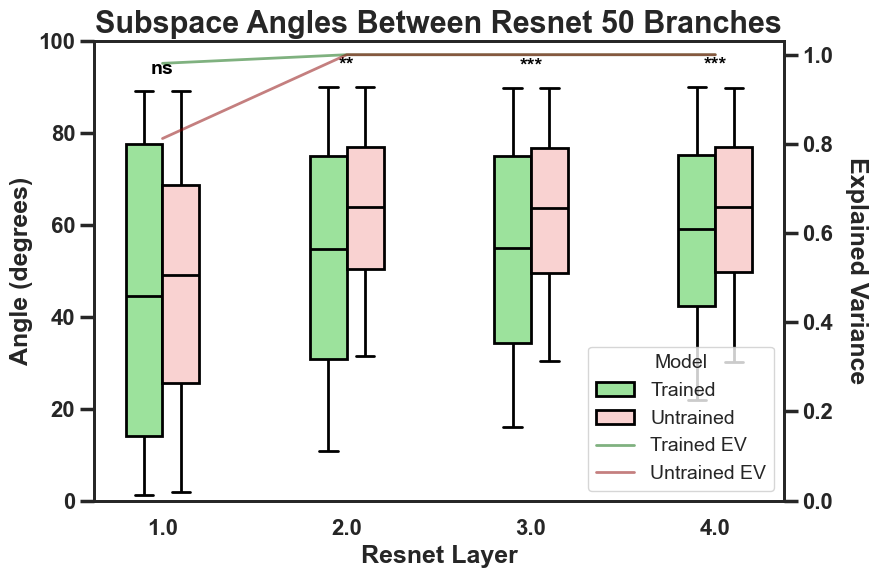

In [113]:
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(9, 6))

# Create the boxplot with seaborn
sns.boxplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            boxprops={'edgecolor': 'k', 'linewidth': 2}, 
            medianprops={'color': 'k', 'linewidth': 2}, 
            whiskerprops={'color': 'k', 'linewidth': 2}, 
            capprops={'color': 'k', 'linewidth': 2}, 
            width=0.4, palette=face_palette, ax=ax1, dodge=True)

# Customize the plot
ax1.set_title('Subspace Angles Between Resnet 50 Branches', weight='bold', fontsize=22)
ax1.set_ylabel('Angle (degrees)', weight='bold', fontsize=18)
ax1.set_xlabel('Resnet Layer', weight='bold', fontsize=18)
ax1.set_xticklabels(['1.0', '2.0', '3.0', '4.0'], weight='bold', fontsize=16)
ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(0, 100)
# make the y ticks bold
plt.yticks(fontweight='bold', fontsize=16)
# Create secondary y-axis for explained variance
ax2 = ax1.twinx()

# Plot explained variance for trained and untrained models with solid, semi-transparent lines
ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
         alpha=0.5, linewidth=2, label='Trained EV')
ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
         alpha=0.5, linewidth=2, label='Untrained EV')

ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25, fontsize=18)
ax2.set_ylim(0, 1.03)
plt.yticks(fontweight='bold', fontsize=16)
# Add legend for explained variance
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')

# Add statistical annotations
add_stat_annotation(ax1, 'Module', 'Angle (degrees)', data, 'Model', p_values)
plt.tight_layout()
plt.show()

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3117/2868254542.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['1.0', '2.0', '3.0', '4.0'], weight='bold', ha='right', rotation=45)


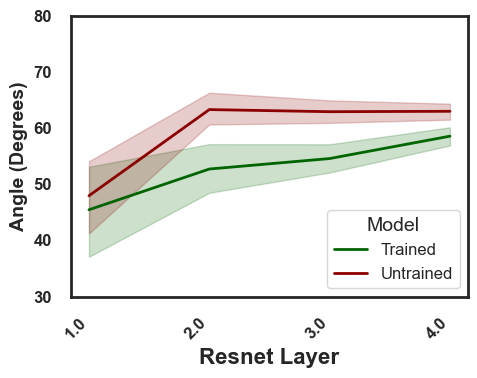

In [114]:
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(5, 4))

# Create the line plot with seaborn for angles
sns.lineplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            linewidth=2, palette=pal, ax=ax1)

# Customize the plot
# ax1.set_title('Mean Subspace Angles and Explained Variance Between Resnet 50 Branches', weight='bold')
ax1.set_ylabel('Angle (Degrees)', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold', fontsize=16)
ax1.set_xticklabels(['1.0', '2.0', '3.0', '4.0'], weight='bold', ha='right', rotation=45)
ax1.legend(title='Model', loc='lower right', fontsize=12)
ax1.set_ylim(30, 80)
plt.yticks(fontweight='bold')

# # Create secondary y-axis for explained variance
# ax2 = ax1.twinx()

# # Plot explained variance for trained and untrained models
# ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Trained EV')
# ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Untrained EV')

# ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
# ax2.set_ylim(0, 1)
plt.yticks(fontweight='bold')
# Combine legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')
# ax1.legend(lines1 , labels1 , loc='lower right', title='Model')

plt.tight_layout()
plt.show()

## Direct Connections Comparison 

Comparing the U Matrix of the 2nd convolutional layer in a resnet block to the V matrix of the 3rd weight layer after SVD. U matrix of second layer represents the output space since the columns of the U matrix span the rows and the weights are flattened into (output_channels, input_channels * h * w) and thus the output is represented by the row dimension. The V transpose matrix from SVD represents the input space since the rows of the matrix span the columsn wehre the inputs are. 

In [115]:
def extract_specific_weights(model, layers_to_extract=['conv2', 'conv3']):
    weights = {}
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            layer_type = name.split('.')[-1]
            if layer_type in layers_to_extract:
                # Get the weight tensor
                weight = module.weight.data.clone().detach()
                
                # Get dimensions
                out_channels, in_channels, kernel_height, kernel_width = weight.shape
                
                # Create an Unfold layer with the same parameters as the Conv2d layer
                unfold = nn.Unfold(kernel_size=(kernel_height, kernel_width), 
                                   dilation=1,
                                   padding=0,
                                   stride=1)
                
                # Apply the Unfold operation
                unfolded_weight = unfold(weight)
                
                # Reshape to (out_channels, in_channels * kernel_height * kernel_width)
                unfolded_weight = unfolded_weight.view(out_channels, -1)
                print(f'Layer: {name}, Unfolded Weight Shape: {unfolded_weight.shape}')

                # Store the unfolded weight
                weights[name] = unfolded_weight.cpu().numpy()
    
    return weights

In [116]:
# Extract conv2 and conv3 weights
conv_weights_trained = extract_specific_weights(resnet)
conv_weights_untrained = extract_specific_weights(resnet_untrained)

trained_weights = conv_weights_trained
untrained_weights = conv_weights_untrained

# Print the weights and names to verify
# for name, weight in conv_weights_trained.items():
#     print(f'Trained - Layer: {name}, Weight shape: {weight.shape}')

Layer: layer1.0.conv2, Unfolded Weight Shape: torch.Size([64, 576])
Layer: layer1.0.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.1.conv2, Unfolded Weight Shape: torch.Size([64, 576])
Layer: layer1.1.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.2.conv2, Unfolded Weight Shape: torch.Size([64, 576])
Layer: layer1.2.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer2.0.conv2, Unfolded Weight Shape: torch.Size([128, 1152])
Layer: layer2.0.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.1.conv2, Unfolded Weight Shape: torch.Size([128, 1152])
Layer: layer2.1.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.2.conv2, Unfolded Weight Shape: torch.Size([128, 1152])
Layer: layer2.2.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.3.conv2, Unfolded Weight Shape: torch.Size([128, 1152])
Layer: layer2.3.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer3.0.conv2, Unfolded Weig

In [117]:
layers_to_compare = ['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1', 'layer4.2']

# results_direct_utov = compare_UtoV(trained_weights, untrained_weights, layers_to_compare)

In [118]:
# save_results(results_direct_utov, 'unf_ev_resnet50_conv2toconv3UtoV.pkl')

In [119]:
layers_to_compare = ['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1', 'layer4.2']


In [120]:
(angles_trained_dict, angles_untrained_dict, data, ev_data) = load_and_process_results('unf_ev_resnet50_conv2toconv3UtoV.pkl')
p_values = get_p_values(angles_trained_dict, angles_untrained_dict)
# save p_values to pickle file called "weight_to_weight_direct_p_values.pkl"
save_results(p_values, 'weight_to_weight_direct_p_values.pkl')
# print number of total angles in angles trained vs angles untrained
print(f"Number of total angles in angles trained: {len(data[data['Model'] == 'Trained'])}")
print(f"Number of total angles in angles untrained: {len(data[data['Model'] == 'Untrained'])}")

angles_trained_dict keys: ['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1', 'layer4.2']
angles_untrained_dict keys: ['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1', 'layer4.2']
Example trained angles type: <class 'list'>
Example untrained angles type: <class 'list'>
Example SVD EV trained type: <class 'list'>
Example SVD EV untrained type: <class 'list'>
Data DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3597 entries, 0 to 3596
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Angle (degrees)  3597 non-null   float32
 1   Model            3597 non-null   object 
 2   Module           3597 non-null   object 
dtypes: float32(1), obj

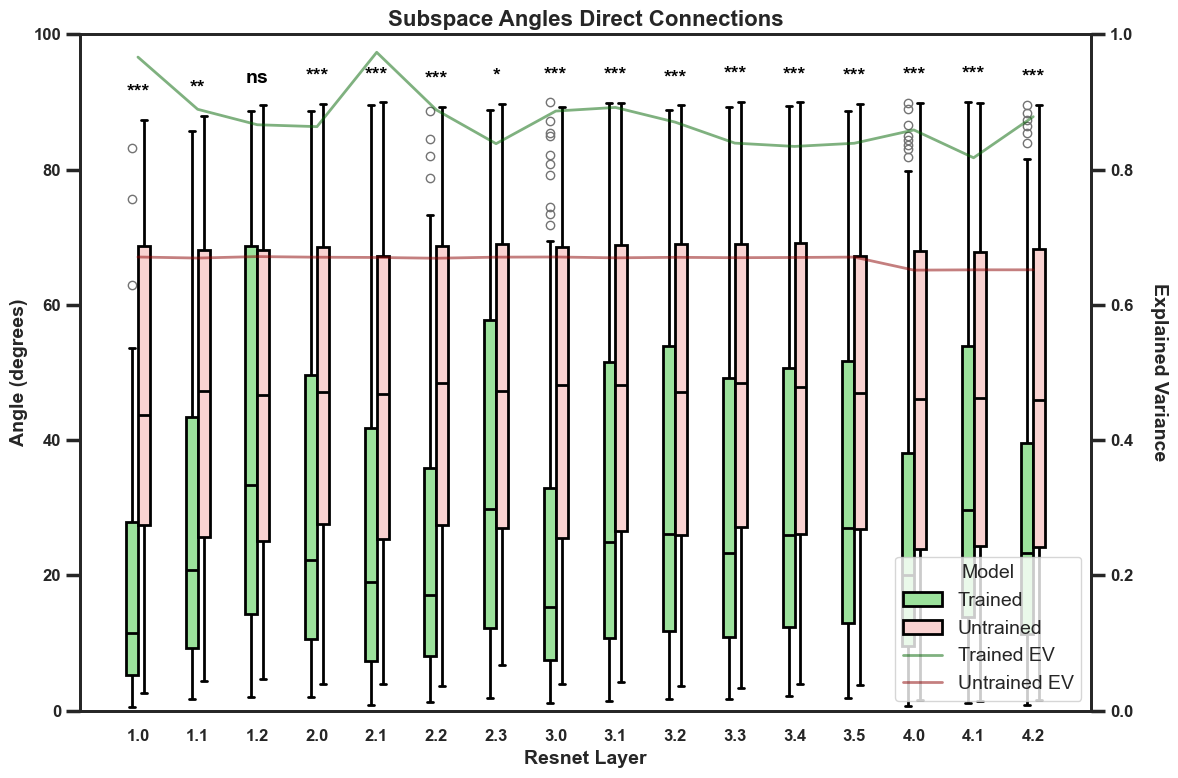

In [121]:
# remove the 'layer' part of the layer names
x_ticks = [layer[5:] for layer in layers_to_compare]

# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the boxplot with seaborn
sns.boxplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            boxprops={'edgecolor': 'k', 'linewidth': 2}, 
            medianprops={'color': 'k', 'linewidth': 2}, 
            whiskerprops={'color': 'k', 'linewidth': 2}, 
            capprops={'color': 'k', 'linewidth': 2}, 
            width=0.4, palette=face_palette, ax=ax1, dodge=True)

# Customize the plot
ax1.set_title('Subspace Angles Direct Connections', weight='bold')
ax1.set_ylabel('Angle (degrees)', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold')
plt.xticks(ticks=np.arange(0, 16), labels=x_ticks, weight='bold')
ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(0, 100)
# make the y ticks bold
plt.yticks(fontweight='bold')
# Create secondary y-axis for explained variance
ax2 = ax1.twinx()

# Plot explained variance for trained and untrained models with solid, semi-transparent lines
ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
         alpha=0.5, linewidth=2, label='Trained EV')
ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
         alpha=0.5, linewidth=2, label='Untrained EV')

ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
ax2.set_ylim(0, 1)
plt.yticks(fontweight='bold')
# Add legend for explained variance
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')


# Add statistical annotations
add_stat_annotation(ax1, 'Module', 'Angle (degrees)', data, 'Model', p_values)
plt.tight_layout()
plt.show()

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3117/2934721081.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels=x_ticks, weight='bold', rotation=45, ha='right')


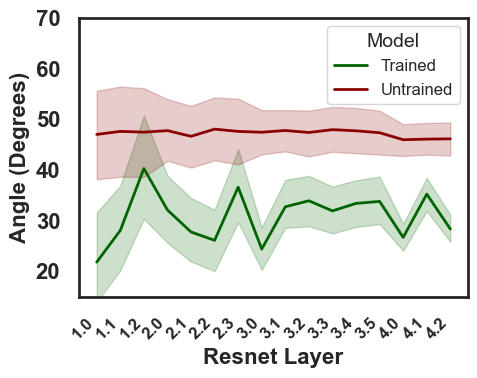

In [122]:
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(5, 4))

# Create the line plot with seaborn for angles
sns.lineplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            linewidth=2, palette=pal, ax=ax1)

# Customize the plot
# ax1.set_title('Mean Subspace Angles Direct Connections', weight='bold', fontsize=22)
ax1.set_ylabel('Angle (Degrees)', weight='bold', fontsize=16)
ax1.set_xlabel('Resnet Layer', weight='bold', fontsize=16)
ax1.set_xticklabels(labels=x_ticks, weight='bold', rotation=45, ha='right')
ax1.legend(title='Model', loc='upper right', fontsize=12)
ax1.set_ylim(15, 70)
plt.yticks(fontweight='bold')

# # Create secondary y-axis for explained variance
# ax2 = ax1.twinx()

# # Plot explained variance for trained and untrained models
# ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Trained EV')
# ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Untrained EV')

# ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
# ax2.set_ylim(0, 1)
plt.yticks(fontweight='bold', fontsize=16)
# # Combine legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# # lines2, labels2 = ax2.get_legend_handles_labels()
# # ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')
# ax1.legend(lines1, labels1, loc='upper right', title='Model', fontsize=12)

plt.tight_layout()
plt.show()

## Indirect Connections

In [123]:
def extract_layer_pairs_from_same_block(conv_weights):
    layer_pairs = []

    for name in conv_weights:
        if 'conv1' in name:
            corresponding_conv3 = name.replace('conv1', 'conv3')
            if corresponding_conv3 in conv_weights:
                layer_pairs.append({
                    'conv1': {
                        'name': name,
                        'shape': conv_weights[name].shape
                    },
                    'conv3': {
                        'name': corresponding_conv3,
                        'shape': conv_weights[corresponding_conv3].shape
                    }
                })

    return layer_pairs

In [124]:
# Example usage
conv_weights_trained = extract_specific_weights(resnet, layers_to_extract=['conv1', 'conv3'])
conv_weights_untrained = extract_specific_weights(resnet_untrained, layers_to_extract=['conv1', 'conv3'])

layer_pairs_trained = extract_layer_pairs_from_same_block(conv_weights_trained)
layer_pairs_untrained = extract_layer_pairs_from_same_block(conv_weights_untrained)

# Print the layer pairs to verify
# for pair in layer_pairs_trained:
#     print(f"Layer pair - Conv1: {pair['conv1']['name']}, Conv3: {pair['conv3']['name']}")

Layer: conv1, Unfolded Weight Shape: torch.Size([64, 147])
Layer: layer1.0.conv1, Unfolded Weight Shape: torch.Size([64, 64])
Layer: layer1.0.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.1.conv1, Unfolded Weight Shape: torch.Size([64, 256])
Layer: layer1.1.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.2.conv1, Unfolded Weight Shape: torch.Size([64, 256])
Layer: layer1.2.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer2.0.conv1, Unfolded Weight Shape: torch.Size([128, 256])
Layer: layer2.0.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.1.conv1, Unfolded Weight Shape: torch.Size([128, 512])
Layer: layer2.1.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.2.conv1, Unfolded Weight Shape: torch.Size([128, 512])
Layer: layer2.2.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.3.conv1, Unfolded Weight Shape: torch.Size([128, 512])
Layer: layer2.3.conv3, Unfolded Weight Shape: torch

In [125]:
# results_indirect_utov = analyze_indirect_UtoV(conv_weights_trained, conv_weights_untrained, layer_pairs_trained)

In [126]:
# save_results(results_indirect_utov, 'unf_ev_resnet50_conv1to3_indirect.pkl')

(angles_trained_dict, angles_untrained_dict, data, ev_data) = load_and_process_results('unf_ev_resnet50_conv1to3_indirect.pkl')
p_values = get_p_values(angles_trained_dict, angles_untrained_dict)
# save p_values to pickle file called "weight_to_weight_indirect_p_values.pkl"
save_results(p_values, 'weight_to_weight_indirect_p_values.pkl')
print(f"Number of total angles in angles trained: {len(data[data['Model'] == 'Trained'])}")
print(f"Number of total angles in angles untrained: {len(data[data['Model'] == 'Untrained'])}")

angles_trained_dict keys: ['layer1.0.conv1', 'layer1.1.conv1', 'layer1.2.conv1', 'layer2.0.conv1', 'layer2.1.conv1', 'layer2.2.conv1', 'layer2.3.conv1', 'layer3.0.conv1', 'layer3.1.conv1', 'layer3.2.conv1', 'layer3.3.conv1', 'layer3.4.conv1', 'layer3.5.conv1', 'layer4.0.conv1', 'layer4.1.conv1', 'layer4.2.conv1']
angles_untrained_dict keys: ['layer1.0.conv1', 'layer1.1.conv1', 'layer1.2.conv1', 'layer2.0.conv1', 'layer2.1.conv1', 'layer2.2.conv1', 'layer2.3.conv1', 'layer3.0.conv1', 'layer3.1.conv1', 'layer3.2.conv1', 'layer3.3.conv1', 'layer3.4.conv1', 'layer3.5.conv1', 'layer4.0.conv1', 'layer4.1.conv1', 'layer4.2.conv1']
Example trained angles type: <class 'list'>
Example untrained angles type: <class 'list'>
Example SVD EV trained type: <class 'list'>
Example SVD EV untrained type: <class 'list'>
Data DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------    

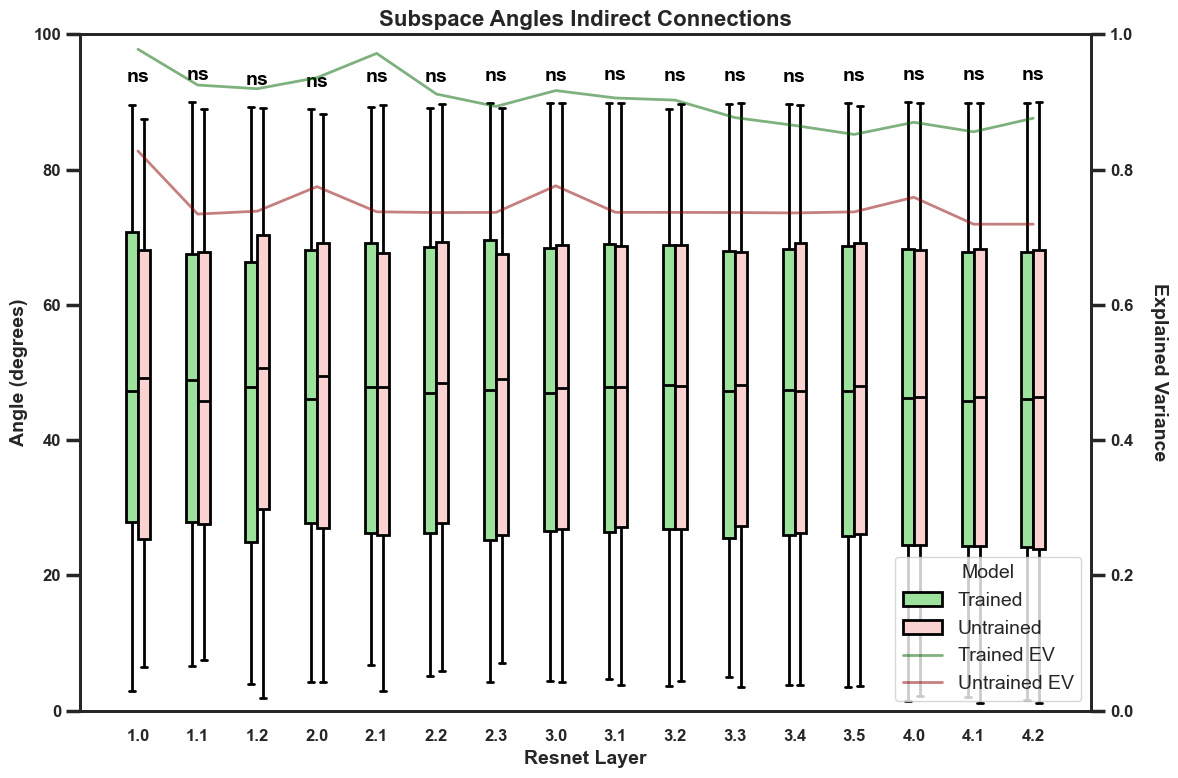

In [127]:
# remove the 'layer' part of the layer names
x_ticks = [layer[5:] for layer in layers_to_compare]

# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the boxplot with seaborn
sns.boxplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            boxprops={'edgecolor': 'k', 'linewidth': 2}, 
            medianprops={'color': 'k', 'linewidth': 2}, 
            whiskerprops={'color': 'k', 'linewidth': 2}, 
            capprops={'color': 'k', 'linewidth': 2}, 
            width=0.4, palette=face_palette, ax=ax1, dodge=True)

# Customize the plot
ax1.set_title('Subspace Angles Indirect Connections', weight='bold')
ax1.set_ylabel('Angle (degrees)', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold')
plt.xticks(ticks=np.arange(0, 16), labels=x_ticks, weight='bold')
ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(0, 100)
# make the y ticks bold
plt.yticks(fontweight='bold')
# Create secondary y-axis for explained variance
ax2 = ax1.twinx()

# Plot explained variance for trained and untrained models with solid, semi-transparent lines
ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
         alpha=0.5, linewidth=2, label='Trained EV')
ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
         alpha=0.5, linewidth=2, label='Untrained EV')

ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
ax2.set_ylim(0, 1)
plt.yticks(fontweight='bold')
# Add legend for explained variance
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')


# Add statistical annotations
add_stat_annotation(ax1, 'Module', 'Angle (degrees)', data, 'Model', p_values)
plt.tight_layout()
plt.show()

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3117/3187553380.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels=x_ticks, weight='bold', rotation=45, ha='right')


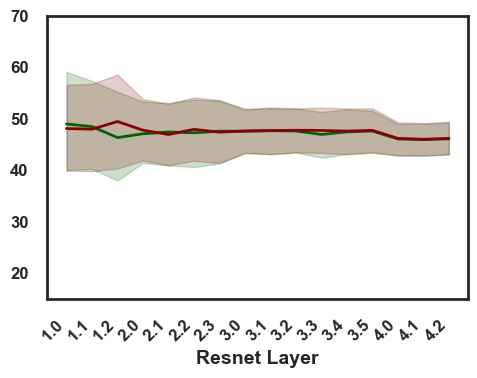

In [128]:
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(5, 4))

# Create the line plot with seaborn for angles
sns.lineplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            linewidth=2, palette=pal, ax=ax1, legend=False)

# Customize the plot
# ax1.set_title('Mean Subspace Angles and Explained Variance Between Resnet 50 Indirect Connections', weight='bold')
ax1.set_ylabel('', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold')
ax1.set_xticklabels(labels=x_ticks, weight='bold', rotation=45, ha='right')
# ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(15, 70)
plt.yticks(fontweight='bold')

# # Create secondary y-axis for explained variance
# ax2 = ax1.twinx()

# # Plot explained variance for trained and untrained models
# ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Trained EV')
# ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Untrained EV')

# ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
# ax2.set_ylim(0, 1)
# plt.yticks(fontweight='bold')
# # Combine legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')

#Save the figure if needed
plt.tight_layout()
plt.show()

## Short Skip Connections Test

In [129]:
# Extract conv1 and conv3 weights
conv_weights_trained = extract_specific_weights(resnet, layers_to_extract=['conv1', 'conv3'])
conv_weights_untrained = extract_specific_weights(resnet_untrained, layers_to_extract=['conv1', 'conv3'])

Layer: conv1, Unfolded Weight Shape: torch.Size([64, 147])
Layer: layer1.0.conv1, Unfolded Weight Shape: torch.Size([64, 64])
Layer: layer1.0.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.1.conv1, Unfolded Weight Shape: torch.Size([64, 256])
Layer: layer1.1.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.2.conv1, Unfolded Weight Shape: torch.Size([64, 256])
Layer: layer1.2.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer2.0.conv1, Unfolded Weight Shape: torch.Size([128, 256])
Layer: layer2.0.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.1.conv1, Unfolded Weight Shape: torch.Size([128, 512])
Layer: layer2.1.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.2.conv1, Unfolded Weight Shape: torch.Size([128, 512])
Layer: layer2.2.conv3, Unfolded Weight Shape: torch.Size([512, 128])
Layer: layer2.3.conv1, Unfolded Weight Shape: torch.Size([128, 512])
Layer: layer2.3.conv3, Unfolded Weight Shape: torch

In [130]:
def extract_shortskip_layer_pairs_from_dict(conv_weights_trained):
    layer_pairs = []
    layer_index_map = {}
    unified_index = 0

    # Map layer names to unified indices
    sorted_keys = sorted(conv_weights_trained.keys())
    for name in sorted_keys:
        if '.conv1' in name or '.conv3' in name:
            layer_name_parts = name.split('.')
            # Join parts up to the second last for conv1 and conv3
            layer_name = '.'.join(layer_name_parts[:-2]) + '.' + layer_name_parts[-2]
            if layer_name not in layer_index_map:
                layer_index_map[layer_name] = unified_index
                unified_index += 1
                #print(f"Layer: {layer_name}, Unified Index: {layer_index_map[layer_name]}")

    # Traverse through sorted keys and find pairs
    prev_conv3_name = None
    prev_conv3_shape = None

    for name in sorted_keys:
        weight_shape = conv_weights_trained[name]

        if name.endswith('.conv3'):
            prev_conv3_name = name
            prev_conv3_shape = weight_shape

        elif name.endswith('.conv1'):
            layer_name_parts = name.split('.')
            current_layer_name = '.'.join(layer_name_parts[:-2]) + '.' + layer_name_parts[-2]
            current_layer_index = layer_index_map[current_layer_name]

            if prev_conv3_name is not None:
                prev_layer_name_parts = prev_conv3_name.split('.')
                prev_layer_name = '.'.join(prev_layer_name_parts[:-2]) + '.' + prev_layer_name_parts[-2]
                prev_layer_index = layer_index_map[prev_layer_name]

                if current_layer_index == prev_layer_index + 1:
                    layer_pairs.append({
                        'prev_conv3': {
                            'name': prev_conv3_name,
                            'shape': prev_conv3_shape
                        },
                        'next_conv1': {
                            'name': name,
                            'shape': weight_shape
                        }
                    })

                    prev_conv3_name = None
                    prev_conv3_shape = None

    return layer_pairs

In [131]:
def sample_layer_pairs_by_level(layer_pairs):
    # Group layer pairs by level
    levels = {}
    for pair in layer_pairs:
        prev_layer_name = pair['prev_conv3']['name']
        level = prev_layer_name.split('.')[0]  # Assuming the level is the first part of the name
        if level not in levels:
            levels[level] = []
        levels[level].append(pair)
    
    # Sample 3 pairs from each level
    sampled_pairs = []
    for level, pairs in levels.items():
        sampled_pairs.extend(random.sample(pairs, min(3, len(pairs))))
    
    return sampled_pairs

In [132]:
# extract the weights of the sampled layer pairs
def extract_sampled_weights(sampled_layer_pairs, conv_weights_trained):
    sampled_weights = {}
    for pair in sampled_layer_pairs:
        prev_conv3_name = pair['prev_conv3']['name']
        next_conv1_name = pair['next_conv1']['name']
        sampled_weights[prev_conv3_name] = conv_weights_trained[prev_conv3_name]
        sampled_weights[next_conv1_name] = conv_weights_trained[next_conv1_name]
    return sampled_weights

In [133]:
# Extract layer pairs
layer_pairs = extract_shortskip_layer_pairs_from_dict(conv_weights_trained)
sampled_layer_pairs = sample_layer_pairs_by_level(layer_pairs)

# Print the layer pairs to verify
for pair in layer_pairs:
    print(f'Trained - Previous Conv3: {pair["prev_conv3"]["name"]}, Next Conv1: {pair["next_conv1"]["name"]}')
    # print the number of layer pairs
print(f'Number of layer pairs in trained model: {len(layer_pairs)}')

print(f'\n Sampled Pairs:')

# print sample pair names
for pair in sampled_layer_pairs:
    print(f'Trained - Previous Conv3: {pair["prev_conv3"]["name"]}, Next Conv1: {pair["next_conv1"]["name"]}')

Trained - Previous Conv3: layer1.0.conv3, Next Conv1: layer1.1.conv1
Trained - Previous Conv3: layer1.1.conv3, Next Conv1: layer1.2.conv1
Trained - Previous Conv3: layer1.2.conv3, Next Conv1: layer2.0.conv1
Trained - Previous Conv3: layer2.0.conv3, Next Conv1: layer2.1.conv1
Trained - Previous Conv3: layer2.1.conv3, Next Conv1: layer2.2.conv1
Trained - Previous Conv3: layer2.2.conv3, Next Conv1: layer2.3.conv1
Trained - Previous Conv3: layer2.3.conv3, Next Conv1: layer3.0.conv1
Trained - Previous Conv3: layer3.0.conv3, Next Conv1: layer3.1.conv1
Trained - Previous Conv3: layer3.1.conv3, Next Conv1: layer3.2.conv1
Trained - Previous Conv3: layer3.2.conv3, Next Conv1: layer3.3.conv1
Trained - Previous Conv3: layer3.3.conv3, Next Conv1: layer3.4.conv1
Trained - Previous Conv3: layer3.4.conv3, Next Conv1: layer3.5.conv1
Trained - Previous Conv3: layer3.5.conv3, Next Conv1: layer4.0.conv1
Trained - Previous Conv3: layer4.0.conv3, Next Conv1: layer4.1.conv1
Trained - Previous Conv3: layer4.1

In [134]:
layers_to_compare = ['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1', 'layer4.2']

skip_weights_trained = extract_sampled_weights(layer_pairs, conv_weights_trained)
skip_weights_untrained = extract_sampled_weights(layer_pairs, conv_weights_untrained)

In [135]:
# # extract the weights of the sampled layer pairs
# sampled_weights_trained = extract_sampled_weights(sampled_layer_pairs, conv_weights_trained)
# sampled_weights_untrained = extract_sampled_weights(sampled_layer_pairs, conv_weights_untrained)
# # print the weight names and shapes
# for name, weight in sampled_weights_trained.items():
#     print(f'Trained - Layer: {name}, Weight shape: {weight.shape}')
# for name, weight in sampled_weights_untrained.items():
#     print(f'Untrained - Layer: {name}, Weight shape: {weight.shape}')

In [136]:
# results_shortskip_utov = compare_shortskip_UtoV(sampled_weights_trained, sampled_weights_untrained, sampled_layer_pairs)

In [137]:
# result_shortskip_utov = compare_shortskip_UtoV(skip_weights_trained, skip_weights_untrained, layer_pairs)

In [138]:
# save_results(result_shortskip_utov, 'unf_ev_resnet50_conv3toconv1ShortSkipAll.pkl')

(angles_trained_dict, angles_untrained_dict, data, ev_data) = load_and_process_results_skip('unf_ev_resnet50_conv3toconv1ShortSkipAll.pkl')

p_values = get_p_values(angles_trained_dict, angles_untrained_dict)
# save p_values to pickle file called "weight_to_weight_shortskip_p_values.pkl"
save_results(p_values, 'weight_to_weight_shortskip_p_values.pkl')
print(f"Number of total angles in angles trained: {len(data[data['Model'] == 'Trained'])}")
print(f"Number of total angles in angles untrained: {len(data[data['Model'] == 'Untrained'])}")


Comparing angles for module layer1.1.conv1:
Shapiro-Wilk test for trained angles: Statistic=0.9415916640315832, p-value=0.005848809623369007
Shapiro-Wilk test for untrained angles: Statistic=0.9611059658738037, p-value=0.041646298722092946
Mann-Whitney U test results: Statistic=1285.0, p-value=0.0009950235351496044
Significant difference found in layer1.1.conv1 with Mann-Whitney U test.

Comparing angles for module layer1.2.conv1:
Shapiro-Wilk test for trained angles: Statistic=0.9527148396501839, p-value=0.015598706733354733
Shapiro-Wilk test for untrained angles: Statistic=0.9597497416913193, p-value=0.03545539457277118
Mann-Whitney U test results: Statistic=1470.0, p-value=0.005921034297736853
Significant difference found in layer1.2.conv1 with Mann-Whitney U test.

Comparing angles for module layer2.1.conv1:
Shapiro-Wilk test for trained angles: Statistic=0.945066271122704, p-value=5.52600488970162e-05
Shapiro-Wilk test for untrained angles: Statistic=0.9640449963537007, p-value=0

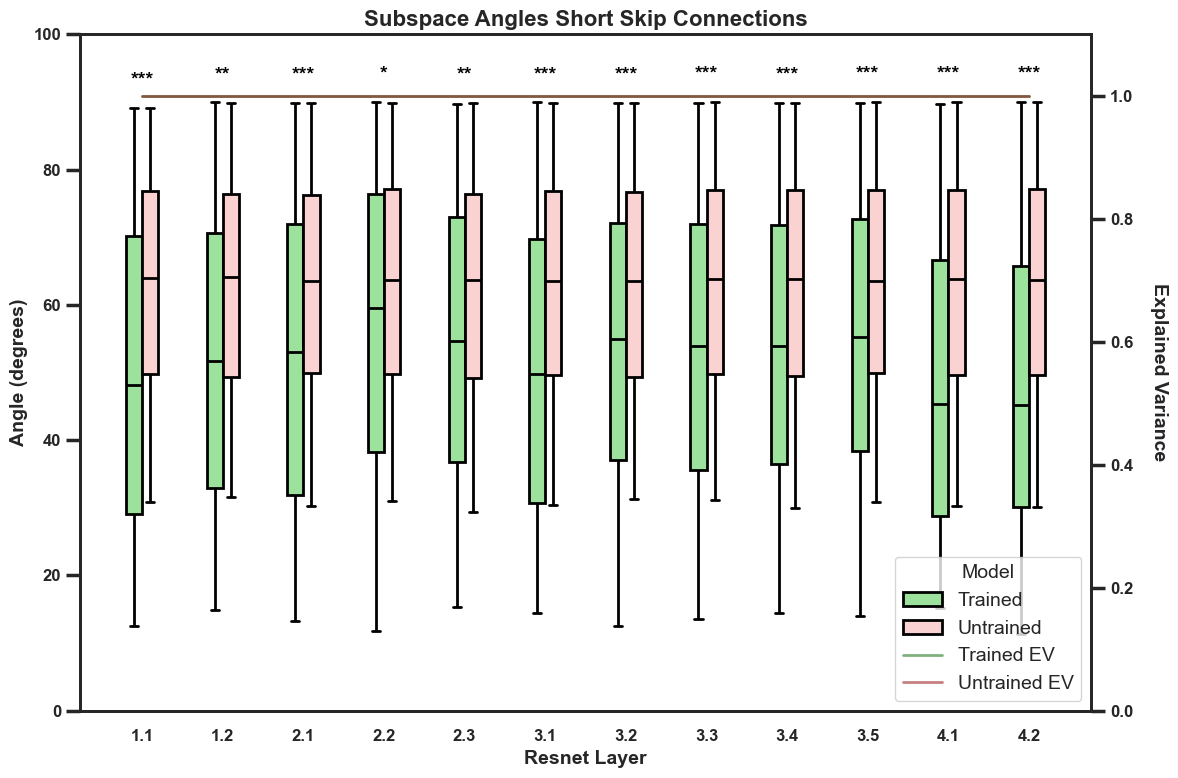

In [139]:

layers_to_compare = ['layer1.1', 'layer1.2', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.1', 'layer4.2']

# remove the 'layer' part of the layer names
x_ticks = [layer[5:] for layer in layers_to_compare]

# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the boxplot with seaborn
sns.boxplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            boxprops={'edgecolor': 'k', 'linewidth': 2}, 
            medianprops={'color': 'k', 'linewidth': 2}, 
            whiskerprops={'color': 'k', 'linewidth': 2}, 
            capprops={'color': 'k', 'linewidth': 2}, 
            width=0.4, palette=face_palette, ax=ax1, dodge=True)

# Customize the plot
ax1.set_title('Subspace Angles Short Skip Connections', weight='bold')
ax1.set_ylabel('Angle (degrees)', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold')
plt.xticks(ticks=np.arange(0, 12), labels=x_ticks, weight='bold')
ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(0, 100)
# make the y ticks bold
plt.yticks(fontweight='bold')
# Create secondary y-axis for explained variance
ax2 = ax1.twinx()

# Plot explained variance for trained and untrained models with solid, semi-transparent lines
ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
         alpha=0.5, linewidth=2, label='Trained EV')
ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
         alpha=0.5, linewidth=2, label='Untrained EV')

ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
ax2.set_ylim(0, 1.1)
plt.yticks(fontweight='bold')
# Add legend for explained variance
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')


# Add statistical annotations
add_stat_annotation(ax1, 'Module', 'Angle (degrees)', data, 'Model', p_values)
plt.tight_layout()
plt.show()

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3117/2794192561.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels=x_ticks, weight='bold', rotation=45, ha='right')


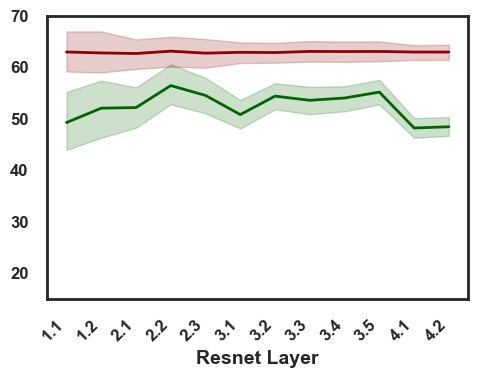

In [140]:
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(5, 4))

# Create the line plot with seaborn for angles
sns.lineplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            linewidth=2, palette=pal, ax=ax1, legend=False)

# Customize the plot
# ax1.set_title('Mean Subspace Angles and Explained Variance Between Resnet 50 Short Skip Connections', weight='bold')
ax1.set_ylabel('', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold')
ax1.set_xticklabels(labels=x_ticks, weight='bold', rotation=45, ha='right')
# ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(15, 70)
plt.yticks(fontweight='bold')

# # Create secondary y-axis for explained variance
# ax2 = ax1.twinx()

# # Plot explained variance for trained and untrained models
# ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Trained EV')
# ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Untrained EV')

# ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
# ax2.set_ylim(0, 1.1)
# plt.yticks(fontweight='bold')
# # Combine legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')

plt.tight_layout()
plt.show()

## Long Skip Connections

In [141]:
def extract_conv1_to_conv1_pairs(conv_weights):
    layer_pairs = []
    layer_index_map = {}
    unified_index = 0

    # Map layer names to unified indices
    sorted_keys = sorted(conv_weights.keys())
    for name in sorted_keys:
        if '.conv1' in name:
            layer_name_parts = name.split('.')
            # Join parts up to the second last for conv1
            layer_name = '.'.join(layer_name_parts[:-2]) + '.' + layer_name_parts[-2]
            if layer_name not in layer_index_map:
                layer_index_map[layer_name] = unified_index
                unified_index += 1

    # Traverse through sorted keys and find conv1 to conv1 pairs
    prev_conv1_name = None
    prev_conv1_shape = None

    for name in sorted_keys:
        weight_shape = conv_weights[name]

        if name.endswith('.conv1'):
            if prev_conv1_name is not None:
                layer_name_parts = name.split('.')
                current_layer_name = '.'.join(layer_name_parts[:-2]) + '.' + layer_name_parts[-2]
                current_layer_index = layer_index_map[current_layer_name]

                prev_layer_name_parts = prev_conv1_name.split('.')
                prev_layer_name = '.'.join(prev_layer_name_parts[:-2]) + '.' + prev_layer_name_parts[-2]
                prev_layer_index = layer_index_map[prev_layer_name]

                if current_layer_index == prev_layer_index + 1:
                    layer_pairs.append({
                        'prev_conv1': {
                            'name': prev_conv1_name,
                            'shape': prev_conv1_shape
                        },
                        'next_conv1': {
                            'name': name,
                            'shape': weight_shape
                        }
                    })

            prev_conv1_name = name
            prev_conv1_shape = weight_shape

    return layer_pairs

In [142]:
# Extract layer pairs
layer_pairs_trained = extract_conv1_to_conv1_pairs(conv_weights_trained)
layer_pairs_untrained = extract_conv1_to_conv1_pairs(conv_weights_untrained)

# Print the layer pairs to verify
for pair in layer_pairs_trained:
    print(f'Trained - Previous Conv1: {pair["prev_conv1"]["name"]}, Next Conv1: {pair["next_conv1"]["name"]}')
    # print the number of layer pairs
print(f'Number of layer pairs in trained model: {len(layer_pairs_trained)}')
# remove all layer pairs with a previous conv1 layer that is not in the basic bottleneck block since the first bottleneck layer has downsample branching and is not a direct skip connection
# remove all pairs with previous conv1 layer that has layerX.0.conv1 in the name
layer_pairs_trained = [pair for pair in layer_pairs_trained if '.0.conv1' not in pair['prev_conv1']['name']]
layer_pairs_untrained = [pair for pair in layer_pairs_untrained if '.0.conv1' not in pair['prev_conv1']['name']]
# print layer pairs to verify
for pair in layer_pairs_trained:
    print(f'Trained - Previous Conv1: {pair["prev_conv1"]["name"]}, Next Conv1: {pair["next_conv1"]["name"]}')
    # print the number of layer pairs
print(f'Number of layer pairs in bottleneck blocks trained model: {len(layer_pairs_trained)}')

Trained - Previous Conv1: layer1.0.conv1, Next Conv1: layer1.1.conv1
Trained - Previous Conv1: layer1.1.conv1, Next Conv1: layer1.2.conv1
Trained - Previous Conv1: layer1.2.conv1, Next Conv1: layer2.0.conv1
Trained - Previous Conv1: layer2.0.conv1, Next Conv1: layer2.1.conv1
Trained - Previous Conv1: layer2.1.conv1, Next Conv1: layer2.2.conv1
Trained - Previous Conv1: layer2.2.conv1, Next Conv1: layer2.3.conv1
Trained - Previous Conv1: layer2.3.conv1, Next Conv1: layer3.0.conv1
Trained - Previous Conv1: layer3.0.conv1, Next Conv1: layer3.1.conv1
Trained - Previous Conv1: layer3.1.conv1, Next Conv1: layer3.2.conv1
Trained - Previous Conv1: layer3.2.conv1, Next Conv1: layer3.3.conv1
Trained - Previous Conv1: layer3.3.conv1, Next Conv1: layer3.4.conv1
Trained - Previous Conv1: layer3.4.conv1, Next Conv1: layer3.5.conv1
Trained - Previous Conv1: layer3.5.conv1, Next Conv1: layer4.0.conv1
Trained - Previous Conv1: layer4.0.conv1, Next Conv1: layer4.1.conv1
Trained - Previous Conv1: layer4.1

In [143]:
# results_longskip_utov = analyze_longskip_UtoV(conv_weights_trained, conv_weights_untrained, layer_pairs_trained)

In [144]:
# save_results(results_longskip_utov, 'unf_ev_resnet50_conv1toconv1LongSkipAll.pkl')

(angles_trained_dict, angles_untrained_dict, data, ev_data) = load_and_process_results_skip('unf_ev_resnet50_conv1toconv1LongSkipAll.pkl')
p_values = get_p_values(angles_trained_dict, angles_untrained_dict)
# save p_values to pickle file called "weight_to_weight_longskip_p_values.pkl"
save_results(p_values, 'weight_to_weight_longskip_p_values.pkl')
print(f"Number of total angles in angles trained: {len(data[data['Model'] == 'Trained'])}")
print(f"Number of total angles in angles untrained: {len(data[data['Model'] == 'Untrained'])}")


Comparing angles for module layer1.2.conv1:
Shapiro-Wilk test for trained angles: Statistic=0.9498102956714035, p-value=0.011199898334818582
Shapiro-Wilk test for untrained angles: Statistic=0.9616465840105172, p-value=0.044414255135149114
Mann-Whitney U test results: Statistic=1431.0, p-value=0.003303580478728982
Significant difference found in layer1.2.conv1 with Mann-Whitney U test.

Comparing angles for module layer2.2.conv1:
Shapiro-Wilk test for trained angles: Statistic=0.9477246795355313, p-value=8.676146365667767e-05
Shapiro-Wilk test for untrained angles: Statistic=0.9622448035406298, p-value=0.001250641365949579
Mann-Whitney U test results: Statistic=6156.0, p-value=0.0005898187533453423
Significant difference found in layer2.2.conv1 with Mann-Whitney U test.

Comparing angles for module layer2.3.conv1:
Shapiro-Wilk test for trained angles: Statistic=0.9553779513326256, p-value=0.0003383320891934814
Shapiro-Wilk test for untrained angles: Statistic=0.9601039529681775, p-val

In [145]:
# print module names from data
module_names = list(angles_trained_dict.keys())
print(module_names)

['layer1.2.conv1', 'layer2.2.conv1', 'layer2.3.conv1', 'layer3.2.conv1', 'layer3.3.conv1', 'layer3.4.conv1', 'layer3.5.conv1', 'layer4.2.conv1']


['1.2', '2.2', '2.3', '3.2', '3.3', '3.4', '3.5', '4.2']


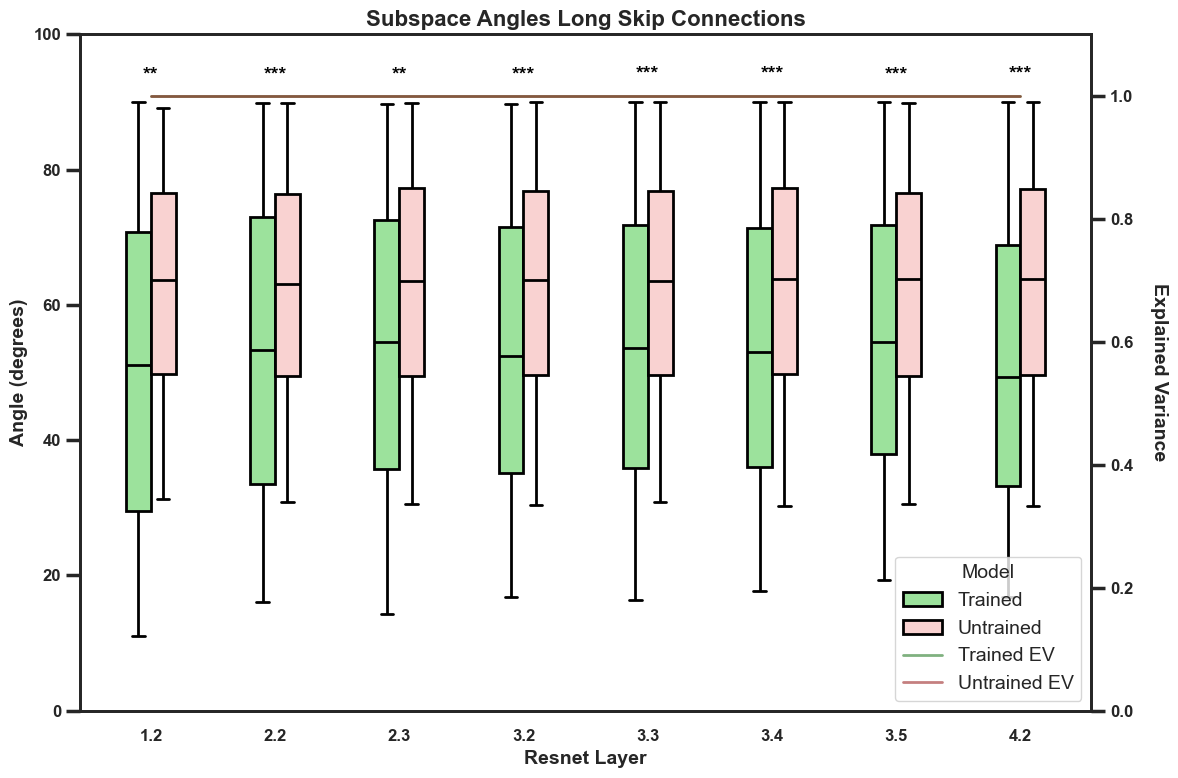

In [146]:
layers_to_compare = ['layer1.2', 'layer2.2', 'layer2.3', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.2']

# remove the 'layer' part of the layer names
x_ticks = [layer[5:] for layer in layers_to_compare]
print(x_ticks)
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the boxplot with seaborn
sns.boxplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            boxprops={'edgecolor': 'k', 'linewidth': 2}, 
            medianprops={'color': 'k', 'linewidth': 2}, 
            whiskerprops={'color': 'k', 'linewidth': 2}, 
            capprops={'color': 'k', 'linewidth': 2}, 
            width=0.4, palette=face_palette, ax=ax1, dodge=True)

# Customize the plot
ax1.set_title('Subspace Angles Long Skip Connections', weight='bold')
ax1.set_ylabel('Angle (degrees)', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold')
plt.xticks(ticks=np.arange(0, 8), labels=x_ticks, weight='bold')
ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(0, 100)
# make the y ticks bold
plt.yticks(fontweight='bold')
# Create secondary y-axis for explained variance
ax2 = ax1.twinx()

# Plot explained variance for trained and untrained models with solid, semi-transparent lines
ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
         alpha=0.5, linewidth=2, label='Trained EV')
ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
         alpha=0.5, linewidth=2, label='Untrained EV')

ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
ax2.set_ylim(0, 1.1)
plt.yticks(fontweight='bold')
# Add legend for explained variance
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')


# Add statistical annotations
add_stat_annotation(ax1, 'Module', 'Angle (degrees)', data, 'Model', p_values)
plt.tight_layout()
plt.show()

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3117/872763614.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels=x_ticks, weight='bold', rotation=45, ha='right')


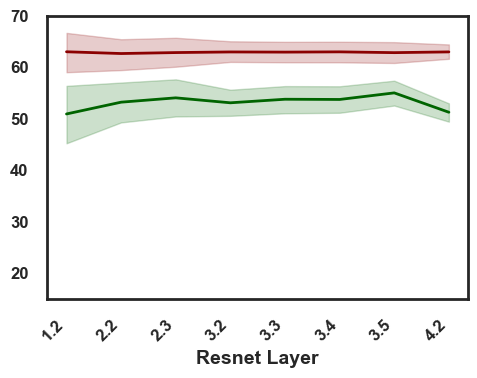

In [147]:
# Plot
sns.set_style(style='white')
fig, ax1 = plt.subplots(figsize=(5, 4))

# Create the line plot with seaborn for angles
sns.lineplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            linewidth=2, palette=pal, ax=ax1, legend=False)

# Customize the plot
# ax1.set_title('Mean Subspace Angles and Explained Variance Between Resnet 50 Long Skip Connections', weight='bold')
ax1.set_ylabel('', weight='bold')
ax1.set_xlabel('Resnet Layer', weight='bold')
ax1.set_xticklabels(labels=x_ticks, weight='bold', rotation=45, ha='right')
# ax1.legend(title='Model', loc='upper left')
ax1.set_ylim(15, 70)
plt.yticks(fontweight='bold')

# # Create secondary y-axis for explained variance
# ax2 = ax1.twinx()

# # Plot explained variance for trained and untrained models
# ax2.plot(range(len(ev_data)), ev_data['Trained_EV'], color=dark_green, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Trained EV')
# ax2.plot(range(len(ev_data)), ev_data['Untrained_EV'], color=dark_red, linestyle='-', 
#          alpha=0.7, linewidth=2, label='Untrained EV')

# ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
# ax2.set_ylim(0, 1.1)
# plt.yticks(fontweight='bold')
# # Combine legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')

plt.tight_layout()
plt.show()

In [148]:
# function to load p_values with the given filename and return the p_values
def load_p_values(filename):
    pickle_folder = 'pickle'
    filepath = os.path.join(pickle_folder, filename)
    
    with open(filepath, 'rb') as f:
        p_values = pickle.load(f)
    
    return p_values

In [149]:
# load all the p-values and make a heatmap with connection type on the x-axis and module on the y-axis
# load the p-values
p_values_direct = load_p_values('weight_to_weight_direct_p_values.pkl')
p_values_indirect = load_p_values('weight_to_weight_indirect_p_values.pkl')
p_values_shortskip = load_p_values('weight_to_weight_shortskip_p_values.pkl')
p_values_longskip = load_p_values('weight_to_weight_longskip_p_values.pkl')
p_values_branching = load_p_values('weight_to_weight_branching_p_values.pkl')
print(p_values_direct)
print(p_values_indirect)
print(p_values_shortskip)
print(p_values_longskip)
print(p_values_branching)

{'layer1.0': np.float64(0.0002297136909263325), 'layer1.1': np.float64(0.0035011673538548815), 'layer1.2': np.float64(0.25805149508623637), 'layer2.0': np.float64(0.0006520365288019334), 'layer2.1': np.float64(4.28935981077567e-05), 'layer2.2': np.float64(2.285361014221827e-06), 'layer2.3': np.float64(0.015424870305341778), 'layer3.0': np.float64(1.1772357065686034e-12), 'layer3.1': np.float64(2.7483906832896264e-06), 'layer3.2': np.float64(3.331747816072378e-05), 'layer3.3': np.float64(6.774897797070433e-07), 'layer3.4': np.float64(8.858000679325906e-06), 'layer3.5': np.float64(1.840552513036339e-05), 'layer4.0': np.float64(2.825658980616197e-17), 'layer4.1': np.float64(1.8408336120551969e-06), 'layer4.2': np.float64(5.349878521108162e-15)}
{'layer1.0.conv1': np.float64(0.8938455697899534), 'layer1.1.conv1': np.float64(0.9357006797280296), 'layer1.2.conv1': np.float64(0.6354714543931639), 'layer2.0.conv1': np.float64(0.86455342640861), 'layer2.1.conv1': np.float64(0.9143153009748918),

In [150]:
# List of connection types and their corresponding p-values
connection_types = {
    'Direct': p_values_direct,
    'Branching': p_values_branching,
    'Shortskip': p_values_shortskip,
    'Longskip': p_values_longskip,
    'Indirect': p_values_indirect

}

# Define the layer names to be included in the DataFrame
layers = [f'{i}.{j}' for i in range(1, 5) for j in range(3)]

# Initialize an empty DataFrame
df = pd.DataFrame(index=layers, columns=connection_types.keys())

# Populate the DataFrame
for conn_type, p_vals in connection_types.items():
    for layer in layers:
        layer_key = f'layer{layer}'
        layer_key_alt = f'{layer_key}.conv1'
        if layer_key in p_vals:
            df.at[layer, conn_type] = p_vals[layer_key]
        elif layer_key_alt in p_vals:
            df.at[layer, conn_type] = p_vals[layer_key_alt]
        else:
            df.at[layer, conn_type] = np.nan

# Display the DataFrame
print(df)

       Direct Branching Shortskip  Longskip  Indirect
1.0   0.00023  0.005152       NaN       NaN  0.893846
1.1  0.003501       NaN  0.000995       NaN  0.935701
1.2  0.258051       NaN  0.005921  0.003304  0.635471
2.0  0.000652  0.000195       NaN       NaN  0.864553
2.1  0.000043       NaN   0.00021       NaN  0.914315
2.2  0.000002       NaN  0.035206   0.00059  0.897681
3.0       0.0       0.0       NaN       NaN  0.982939
3.1  0.000003       NaN       0.0       NaN  0.990356
3.2  0.000033       NaN  0.000007       0.0  0.972557
4.0       0.0       0.0       NaN       NaN  0.957295
4.1  0.000002       NaN       0.0       NaN   0.97901
4.2       0.0       NaN       0.0       0.0  0.973086


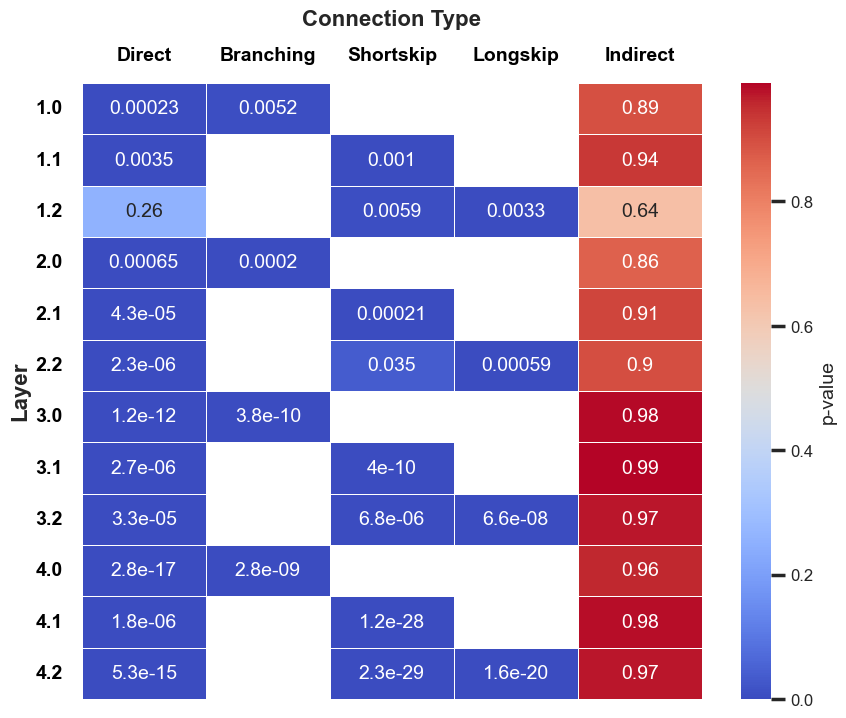

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the DataFrame to float, replacing NaNs with a placeholder (e.g., np.nan)
df_float = df.astype(float)

# Create a heatmap of the DataFrame
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_float, annot=True, cmap='coolwarm', cbar_kws={'label': 'p-value'}, linewidths=.5)

# Move x-axis labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Set the axis labels and title with bold and larger font size
plt.xlabel('Connection Type', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Layer', fontsize=16, fontweight='bold')

# Customize the tick labels with bold font and larger size
ax.tick_params(axis='x', labelsize=14, width=0, labelrotation=0, labelcolor='black', labelbottom=False, labeltop=True)
ax.tick_params(axis='y', labelsize=14, labelrotation=0, labelcolor='black')

# Manually set the fontweight for tick labels
for tick in ax.get_xticklabels():
    tick.set_fontsize(14)
    tick.set_fontweight('bold')

for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
    tick.set_fontweight('bold')

# Remove the lines connecting the xtick labels to the columns
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the heatmap
plt.show()
